In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import datetime


from datetime import timedelta, datetime, date
import calendar

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import os
import glob


# This is my preprocessing function, which I run on each grib file

# Load, preprocess, append, and concatenate all the grib files. In this notebook I ran it on half of the data available.

### I will comment the code below for pr_sfc. I repeat the code for each variable separiately. I could loop it for a list of varname =[ 'pr_sfc' , ....] but I preferred keeping it separate.

In [2]:
from glob import glob
variable_names = ['pr_sfc']

def ppf2_filename(ds,filename):
    # rename coordinates
    ds  = ds.rename({ 'lon_0':'lon', 'lat_0':'lat', 'forecast_time0':'time'})
    # getting start time from file name
    ts = filename.split('_')
#     print(ts)
    whereGEFS = ts.index('GEFS')
#     print(whereGEFS)
    dateSstr = ts[whereGEFS+1]
#     print(dateSstr)
    dateS = datetime.strptime(dateSstr, '%d%b%Y')
#     print(dateS)
    
    Mvalue = np.int(float(np.asarray(ts[-1][2:4])))

    ds.coords['S'] = 'S', np.atleast_1d(dateS)
    ds.coords['M'] = 'M', np.atleast_1d(Mvalue)
    
    ds.coords['time']=np.array([  43200000000000,  129600000000000,  216000000000000,
        302400000000000,  388800000000000,  475200000000000,
        561600000000000,  648000000000000,  734400000000000,
        820800000000000,  907200000000000,  993600000000000,
       1080000000000000, 1166400000000000, 1252800000000000,
       1339200000000000, 1425600000000000, 1512000000000000,
       1598400000000000, 1684800000000000, 1771200000000000,
       1857600000000000, 1944000000000000, 2030400000000000,
       2116800000000000, 2203200000000000, 2289600000000000,
       2376000000000000, 2462400000000000, 2548800000000000,
       2635200000000000, 2721600000000000, 2808000000000000,
       2894400000000000, 2980800000000000],
      dtype='timedelta64[ns]')

    # select US
    ds = ds.sel(lat=slice(50,23), lon=slice(230,300))
#     print(ds)
    return ds

def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
#         print(path)
        with xr.open_dataset(path, engine='pynio', chunks={}) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds, path)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
#             print(ds)
#             ds.load()
            return ds
#     print(files)
    paths = sorted(glob(files))
#     print(paths)
    datasets = [process_one_path(p) for p in paths]
    
    combined = xr.combine_by_coords(datasets)
    combined = combined.chunk({'S':4,'M':-1})
    return combined

var_l=[]
for ivx, ivar in enumerate(variable_names):
    print(ivar)
    if ivar in os.listdir('/Data2/SubX/EMC/GEFS/'):
        c_l = []
        for iy in np.arange(1999, 2017):#2017
            print(iy)
            # here we suppose we only care about the combined mean of each file;
            # you might also use indexing operations like .sel to subset datasets
            combined = read_netcdfs('/Data2/SubX/EMC/GEFS/'+ivar+'/'+np.str(iy)+'/*/*.grb2', dim=['S','M'],
                                    transform_func=ppf2_filename)
            
            c_l.append(combined)
    all_values = xr.concat(c_l, dim='S') 
    var_l.append(all_values)


pr_sfc
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016


In [3]:
all_variables = xr.merge(var_l)
all_variables

<xarray.Dataset>
Dimensions:          (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lon              (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * M                (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat              (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
  * time             (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * S                (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
Data variables:
    APCP_P1_L1_GLL0  (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [4]:
all_variables = all_variables.rename({'APCP_P1_L1_GLL0':'pr_sfc'})

In [5]:
all_variables

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 dask.array<chunksize=(4, 10, 35, 28, 71), meta=np.ndarray>

In [6]:
all_variables.load()

<xarray.Dataset>
Dimensions:  (M: 10, S: 939, lat: 28, lon: 71, time: 35)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * M        (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * time     (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
  * S        (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-21 2016-12-28
Data variables:
    pr_sfc   (S, M, time, lat, lon) float32 1.1 1.2 1.0 ... 0.84 0.65999997 0.39

In [7]:
all_variables.coords['target_time'] = all_variables.S+all_variables.time


# Does climatology depend on lead times?

# calculate climatology for a handful of Target dates (3 day accumulated rain) by pooling 5 S dates and a range of L 1-5, 7-11, 13-17

In [8]:
# Generate target time to check on L dependnece 
target = [ '1900-'+np.str(month).zfill(2)+'-'+np.str(15).zfill(2) for month in np.arange(1,13)]
# transform them in correct dtype
target = [np.datetime64(it) for it in target ]
target = [pd.DatetimeIndex([it]) for it in target ]

In [9]:
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES'  

i_v_u ='EMC/.GEFS'
#                'GMAO/.GEOS_V2p1',
#                'NRL/.NESM',
#                'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              #]

ds_mask = xr.open_dataset(MASK_url+i_v_u+MASK_url1+url3+MASK_url2)
ds_mask['the_geom']=xr.where(ds_mask.the_geom!=0, 1, 0)

ds_mask = ds_mask.rename({'X':'lon', 'Y':'lat'})
ds_mask = ds_mask.isel(objectid=0, drop=True)
ds_mask.coords['lon'] = ds_mask.lon+360.



# re do this with accumulated 3 day rainfall. The accumulation (rolling sum) is done along L

In [10]:
all_variables_3L = all_variables.rolling(time=3).sum()


# The rolling sum assign the right edge value of the interval

In [11]:
all_variables_3L.pr_sfc[0,0,:,10,20]

<xarray.DataArray 'pr_sfc' (time: 35)>
array([           nan,            nan,  1.0000000e-01,  1.0000000e-01,
        1.0000000e-01,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  3.4000001e+00,  6.6999998e+00,  7.2999997e+00,
        1.2400000e+01,  9.0999994e+00,  8.4999990e+00, -9.5367432e-07,
        3.9999990e+00,  3.9999990e+00,  3.9999990e+00, -9.5367432e-07,
       -9.5367432e-07,  9.9999048e-02,  2.9999906e-01,  2.9999906e-01,
        1.9999906e-01, -9.3877316e-07,  1.9999906e-01,  1.9999906e-01,
        1.9999906e-01, -9.3877316e-07,  9.9999063e-02,  9.9999063e-02,
        9.9999063e-02,  9.9999905e-01,  9.9999905e-01], dtype=float32)
Coordinates:
    lon          float32 250.0
    M            int64 0
    lat          float32 40.0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 34 days 12:00:00
    S            datetime64[ns] 1999-01-06
    target_time  (time) datetime64[ns] 1999-01-06T12:00:00 ... 1999-02-09T12:00:00

# Here I switch to the left edge of the interval

In [12]:
all_variables_3L.coords['time'] = all_variables_3L.time.values-np.timedelta64(2,'D')

# And drop the first 2 empty values

In [13]:
all_variables_3L = all_variables_3L.isel(time=slice(2,36))
all_variables_3L.pr_sfc[0,0,:,10,20]

<xarray.DataArray 'pr_sfc' (time: 33)>
array([ 1.0000000e-01,  1.0000000e-01,  1.0000000e-01,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  3.4000001e+00,
        6.6999998e+00,  7.2999997e+00,  1.2400000e+01,  9.0999994e+00,
        8.4999990e+00, -9.5367432e-07,  3.9999990e+00,  3.9999990e+00,
        3.9999990e+00, -9.5367432e-07, -9.5367432e-07,  9.9999048e-02,
        2.9999906e-01,  2.9999906e-01,  1.9999906e-01, -9.3877316e-07,
        1.9999906e-01,  1.9999906e-01,  1.9999906e-01, -9.3877316e-07,
        9.9999063e-02,  9.9999063e-02,  9.9999063e-02,  9.9999905e-01,
        9.9999905e-01], dtype=float32)
Coordinates:
    lon          float32 250.0
    M            int64 0
    lat          float32 40.0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
    S            datetime64[ns] 1999-01-06
    target_time  (time) datetime64[ns] 1999-01-08T12:00:00 ... 1999-02-09T12:00:00

# Update the target time, because those have not changed and they are still linked to the right edge of the interval

In [14]:
all_variables_3L.coords['target_time'] = all_variables_3L.S+all_variables_3L.time
all_variables_3L

<xarray.Dataset>
Dimensions:      (M: 10, S: 939, lat: 28, lon: 71, time: 33)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * time         (time) timedelta64[ns] 0 days 12:00:00 ... 32 days 12:00:00
  * S            (S) datetime64[ns] 1999-01-06 1999-01-13 ... 2016-12-28
    target_time  (S, time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
Data variables:
    pr_sfc       (S, M, time, lat, lon) float32 10.5 3.5 ... 1.3400015 1.0199976

In [15]:
all_variables_T3 = all_variables_3L.stack(St=('S','time'))
all_variables_T3 = all_variables_T3.swap_dims({'St':'target_time'})
all_variables_T3 = all_variables_T3.unstack()


In [16]:
all_variables_T3

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, target_time: 30987)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * target_time  (target_time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (target_time) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
Data variables:
    pr_sfc       (M, lat, lon, target_time) float32 10.5 38.1 ... 1.0199976

In [17]:
target

[DatetimeIndex(['1900-01-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-02-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-03-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-04-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-05-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-06-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-07-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-08-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-09-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-10-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-11-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['1900-12-15'], dtype='datetime64[ns]', freq=None)]

In [18]:
# Generate target time to check on L dependnece 
target_all = pd.date_range('1900-01-01', periods=365, freq='D')
target_all = [pd.DatetimeIndex([it]) for it in target_all]
# target_all

In [19]:
# looping through the target dates for climatologies
ds_clim_test_3d_all = []
for iT in target_all:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
    
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        temp3 = temp2.stack(Mtt=('M','target_time'))
#         print(temp3.pr_sfc.values.shape)
        temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
        temp3 = temp3.expand_dims('Lbeg')
        temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
#         print(temp3)
        if different_lead1==1:
            ds_quantile = temp3*1.
        else:
            ds_quantile = xr.merge([ds_quantile,temp3])
    ds_quantile = ds_quantile.expand_dims('target_clim')
    ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    ds_clim_test_3d_all.append(ds_quantile)
ds_clim_test_3d_all = xr.combine_by_coords(ds_clim_test_3d_all)    


In [20]:
# # looping through the target dates for climatologies
# ds_clim_test_3d_all_wq = []
# for iT in target_all:
#     # extract values that correspond to the target dates
#     temp = all_variables_T3.where((all_variables_T3.target_time.values>=(iT-pd.Timedelta(2,'D')).values)&
#                               (all_variables_T3.target_time.values<=(iT+pd.Timedelta(2,'D')).values), drop=True)
    
#     # bits to extract the S and t of each target_time
#     y_ls = [y for (x,y) in temp.St.values]
#     y_arr = np.array(y_ls)
#     pause
#     # loop through the 3 types of lead times
#     # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
# #     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
#     for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
# #         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
#         temp2 = temp.sel(target_time=
#                          (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
#         temp3 = temp2.stack(Mtt=('M','target_time'))
# #         print(temp3.pr_sfc.values.shape)
#         temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
#         temp3 = temp3.expand_dims('Lbeg')
#         temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
# #         print(temp3)
#         if different_lead1==1:
#             ds_quantile = temp3*1.
#         else:
#             ds_quantile = xr.merge([ds_quantile,temp3])
#     ds_quantile = ds_quantile.expand_dims('target_clim')
#     ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
#     ds_clim_test_3d_all_wq.append(ds_quantile)
# ds_clim_test_3d_all_wq = xr.combine_by_coords(ds_clim_test_3d_all_wq)    


In [21]:
# times = pd.date_range('2000-01-01', '2010-12-31', name='time')
# annual_cycle = np.sin(2 * np.pi * (times.dayofyear.values / 366 - 0.28))
# noise = 15 * np.random.rand(annual_cycle.size)
# data = 10 + (15 * annual_cycle) + noise
# da = xr.DataArray(data, coords=[times], dims='time')
# #da.plot()
# #Check variability at one day
# #da.groupby('time.dayofyear').std('time')[0]
# da_clim = da.groupby('time.dayofyear').mean('time')
# _da_clim = xr.concat([da_clim[-15:], da_clim, da_clim[:15]], 'dayofyear')
# da_clim_smooth = _da_clim.rolling(dayofyear=31, center=True).mean().dropna('dayofyear')
# da_clim_smooth.plot()

In [22]:
four_day_periods = [(4 * ((all_variables_T3.target_time.dt.dayofyear - n) // 4) % 365)
                    for n in range(4)]
for p in four_day_periods:
    #print(p.values[:12])
    print(all_variables_T3.target_time.dt.dayofyear.groupby(p).mean().values[-10:])

[329.50439883 333.5        337.50146628 341.50591716 345.49411765
 349.50442478 353.48967552 357.50439883 361.5        364.68556701]
[330.50146628 334.50591716 338.49411765 342.50442478 346.48967552
 350.50439883 354.5        358.50146628 362.50591716 365.22018349]
[335.50442478 339.48967552 343.50439883 347.5        351.50146628
 355.50591716 359.49411765 363.50442478   1.         366.        ]
[332.48967552 336.50439883 340.5        344.50146628 348.50591716
 352.49411765 356.50442478 360.48967552 364.17204301   1.5       ]


In [23]:
ds = all_variables_T3
time = all_variables_T3.target_time
doy = time.dt.dayofyear
year =  time.dt.year
ds

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, target_time: 30987)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * target_time  (target_time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (target_time) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
Data variables:
    pr_sfc       (M, lat, lon, target_time) float32 10.5 38.1 ... 1.0199976

In [336]:
ds = ds.drop(['year', 'dayofyear'])

In [340]:
import pandas as pd
midx = pd.MultiIndex.from_arrays([year, doy])
ds.coords['midx'] = 'target_time', midx
ds_sd = ds.swap_dims({'target_time': 'midx'})
ds_sd

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, midx: 30987)
Coordinates:
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
    target_time  (midx) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (midx) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
  * midx         (midx) MultiIndex
  - year         (midx) int64 1999 1999 1999 1999 1999 ... 2017 2017 2017 2017
  - dayofyear    (midx) int64 6 7 8 9 10 11 12 13 14 ... 22 23 24 25 26 27 28 29
Data variables:
    pr_sfc       (M, lat, lon, midx) float32 10.5 38.1 ... 0.94999754 1.0199976

In [20]:
# ds_sd.unstack('midx')

In [306]:
gb = all_variables_T3.groupby(four_day_period)
for name, group in gb:
    break
group.target_time

<xarray.DataArray 'target_time' (target_time: 254)>
array(['2000-01-01T12:00:00.000000000', '2000-01-02T12:00:00.000000000',
       '2000-01-01T12:00:00.000000000', ..., '2017-01-01T12:00:00.000000000',
       '2017-01-02T12:00:00.000000000', '2017-01-03T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * target_time  (target_time) datetime64[ns] 2000-01-01T12:00:00 ... 2017-01-03T12:00:00
    St           (target_time) object (Timestamp('1999-12-01 00:00:00'), Timedelta('31 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('6 days 12:00:00'))

In [313]:
gm = gb.mean(dim='target_time')
gm

<xarray.Dataset>
Dimensions:    (M: 10, dayofyear: 92, lat: 28, lon: 71)
Coordinates:
  * lat        (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * M          (M) int64 0 1 2 3 4 5 6 7 8 9
  * lon        (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * dayofyear  (dayofyear) int64 0 4 8 12 16 20 24 ... 344 348 352 356 360 364
Data variables:
    pr_sfc     (dayofyear, M, lat, lon) float32 23.46221 27.545752 ... 6.050516

In [305]:
np.array([1, 2, 3, 4, 5]) // 4

array([0, 0, 0, 1, 1])

In [34]:
ds_clim_test_3d_all3 = ds_clim_test_3d_all.rolling(target_clim=3, center=True).mean()
ds_clim_test_3d_all5 = ds_clim_test_3d_all.rolling(target_clim=5, center=True).mean()

# FITTING PROCEDURES

In [41]:
for ir in range(2, 5,2):
    print( ir)

2
4


In [24]:
def fffourier(x, *a):
    '''harmonic just with cosine'''
    tau = 366
    ret = a[1] * np.cos(2* np.pi / tau * x)
    for deg in range(2, len(a)):
        ret += a[deg] * np.cos((deg) *2* np.pi / tau * x)
    return ret +a[0]

In [423]:
def fffourierB(x, *a_in):
    '''harmonic with np.exp(sum(sine and cosine))'''
    a_0 = a_in[0]
    len_a = len(a_in)-1
#     print(len_a, int(len_a/2))
    if len_a==3:
        a = a_in[1]
        b = a_in[2]
    else:
        a = a_in[1:int(len_a/2+1)]
        b = a_in[int(len_a/2+1):]
#     print(a,b)
    tau = 365.25
    nu = 2*np.pi/tau
    ret = a_0
    for deg in range(0,int(len_a/2)):
#         print(deg)
#         print(a[deg] , b[deg] )
        ret += a[deg] * np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
#     if any(np.abs(a))>=19:
#         ret*=10000
#     if any(np.abs(b))>=19:
#         ret*=10000
    return np.exp(ret)

In [98]:
def fffourierC(x, *a_in):
    '''harmonic with sum(sine and cosine)'''
    a_0 = a_in[0]
    len_a = len(a_in)-1
#     print(len_a, int(len_a/2))
    if len_a==3:
        a = a_in[1]
        b = a_in[2]
    else:
        a = a_in[1:int(len_a/2+1)]
        b = a_in[int(len_a/2+1):]
#     print(a,b)
    tau = 365.25
    nu = 2*np.pi/tau
    ret = a_0
    for deg in range(0,int(len_a/2)):
#         print(deg)
#         print(a[deg] , b[deg] )
        ret += a[deg] * np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
    return ret

In [99]:
def fffourierL(x, *a_in):
    '''harmonic with sum(sine and cosine) to the log of intensity'''

    a_0 = a_in[0]
    len_a = len(a_in)-1
#     print(len_a, int(len_a/2))
    if len_a==3:
        a = a_in[1]
        b = a_in[2]
    else:
        a = a_in[1:int(len_a/2+1)]
        b = a_in[int(len_a/2+1):]
#     print(a,b)
    tau = 365.25
    nu = 2*np.pi/tau
    ret = a_0
    for deg in range(0,int(len_a/2)):
#         print(deg)
#         print(a[deg] , b[deg] )
        ret +=a[deg]*np.sin((deg+1) * nu * x) + b[deg] * np.cos((deg+1) * nu * x)
    return ret

In [100]:
from scipy.optimize import curve_fit
x = ds_clim_test_3d_all.target_clim.dt.dayofyear.values
y = ds_clim_test_3d_all.pr_sfc[:,3,-1,2,30].values

# x = np.concatenate((x[290:]-365,x,x[:100]+365))
# y =  np.concatenate((y[290:],y,y[:100]))
popt, pcov = curve_fit(fffourierB, x,y, [1]*9)
# popt, pcov = curve_fit(fffourier, x,y, [0] * 9)
print(popt)

[ 2.04826574  0.12223234 -0.16128392 -0.01035386 -0.12864251 -0.68009917
 -0.04334656  0.02782981  0.03241101]


In [101]:
popt

array([ 2.04826574,  0.12223234, -0.16128392, -0.01035386, -0.12864251,
       -0.68009917, -0.04334656,  0.02782981,  0.03241101])

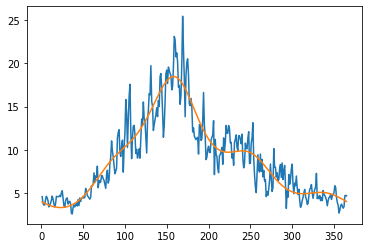

In [102]:
plt.plot(x,y)
plt.plot(x,fffourierB(x,  *popt) )

In [103]:
def apply_fffourier(dsin):
    x = dsin.target_clim.dt.dayofyear.values
#     print(dsin)
#     print(x.shape)
    popt = dsin.H.values
    out = fffourierB(x, *popt)
#     print(out)
#     pause
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)


In [104]:
def apply_fffourierL(dsin):
    x = dsin.target_clim.dt.dayofyear.values
#     print(dsin)
#     print(x.shape)
    popt = dsin.H.values
    out = fffourierL(x, *popt)
#     print(out)
#     pause
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)


In [105]:
def apply_fffourierC(dsin):
    x = dsin.target_clim.dt.dayofyear.values
#     print(dsin)
#     print(x.shape)
    popt = dsin.H.values
    out = fffourierC(x, *popt)
#     print(out)
#     pause
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(out)


In [381]:
def apply_fit_curveb(dsin, loss_f):
    x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
    y = dsin.values
#     print(y.shape)
#     pause
#     print(y)
    
    if np.sum(np.isnan(y))==0:
        y[y<0]=0

        try:
            num_armonics = 9
            popt, pcov = curve_fit(fffourierB, x,y, [10.0] * num_armonics, bounds=[-20,20], maxfev=3000)
        except:
            try:
                num_armonics = 7
                print(7)
                print(dsin.coords)
                popt, pcov = curve_fit(fffourierB, x,y, [1.0] * num_armonics,bounds=[-20,20])
            except:
                try:
                    num_armonics = 5
                    print(5)
                    print(dsin.coords)
                    popt, pcov = curve_fit(fffourierB, x,y[:,0], [1.0] * num_armonics, bounds=[-20,20])
                except:
                    try:
                        num_armonics = 3
                        print(3)
                        print(dsin.coords)
                        popt, pcov = curve_fit(fffourierB, x,y[:,0], [1.0] * num_armonics, bounds=[-20,20])
                    except:
                        print('failed', dsin)
                        popt = np.nan*np.ones(3)
    else:
        popt=np.nan*np.ones(9)
        num_armonics = 9
#     popt, pcov = curve_fit(fffourierB, x,y[:,0], [10.0] * 9)
#     print(popt)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')
#     return xr.DataArray(popt, coords=[np.arange(0,9)], dims='harmonic')


In [444]:
def apply_fit_curve_cauchy(dsin):
#     print(loss_f[:])
#     pause
    x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
    y = dsin.pr_sfc.values[:,0]
    if np.sum(np.isnan(y))==0:
        y[y<0]=0

#         try:
#             num_armonics = 9
#             popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-15,15])
#         except:
#         try:
        num_armonics = 7
        popt, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], loss='cauchy')
#         except:
#             try:
#                 num_armonics = 5
#                 print(5)
#                 print(dsin.coords)
#                 popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20],
#                                        loss='cauchy')
#             except:
#                 try:
#                     num_armonics = 3
#                     print(3)
#                     print(dsin.coords)
#                     popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20], 
#                                            loss='cauchy')
#                 except:
#                     print('failed', dsin)
#                     popt = np.nan*np.ones(3)
    else:
        popt=np.nan*np.ones(7)
        num_armonics = 7

    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')


In [434]:
def apply_fit_curve_soft(dsin):
#     print(loss_f[:])
#     pause
    x = dsin.target_clim.dt.dayofyear.values
#     print(x.shape)
    y = dsin.pr_sfc.values[:,0]
    
    if np.sum(np.isnan(y))==0:
        y[y<0]=0

#         try:
#             num_armonics = 9
#             popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-15,15])
#         except:
#         try:
        num_armonics = 7
        popt, pcov = curve_fit(fffourierB, x,y, [0.0] * num_armonics, bounds=[-20,20], loss='soft_l1')
        
#         except:
#             try:
#                 num_armonics = 5
#                 print(5)
#                 print(dsin.coords)
#                 popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20],
#                                        loss='soft_l1')
#             except:
#                 try:
#                     num_armonics = 3
#                     print(3)
#                     print(dsin.coords)
#                     popt, pcov = curve_fit(fffourierB, x,y[:,0], [0.0] * num_armonics, bounds=[-20,20], 
#                                            loss='soft_l1')
#                 except:
#                     print('failed', dsin)
#                     popt = np.nan*np.ones(3)
    else:
        popt=np.nan*np.ones(7)
        num_armonics = 7

    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(popt, coords=[np.arange(0,num_armonics)], dims='harmonic')


In [36]:
ds_clim_test_3d_all.isel(quantile=slice(-3, None))

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, quantile: 3, target_clim: 365)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * Lbeg         (Lbeg) int64 2 4 6 8
  * quantile     (quantile) float64 0.5 0.667 0.85
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, quantile, lat, lon) float64 13.7 ... 12.7

# Apply curve fit


In [225]:
stacked.pr_sfc

<xarray.DataArray 'pr_sfc' (target_clim: 365, allpoints: 7952)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
  * allpoints    (allpoints) MultiIndex
  - quantile     (allpoints) float64 0.85 0.85 0.85 0.85 ... 0.85 0.85 0.85 0.85
  - Lbeg         (allpoints) int64 2 2 2 2 2 2 2 2 2 2 2 ... 8 8 8 8 8 8 8 8 8 8
  - lat          (allpoints) float64 50.0 50.0 50.0 50.0 ... 23.0 23.0 23.0 23.0
  - lon          (allpoints) float64 230.0 231.0 232.0 ... 298.0 299.0 300.0

In [320]:
# stacked = ds_clim_test_3d_all.where(ds_mask.the_geom>0).isel(quantile=slice(-1, None)).stack(
stacked = ds_clim_test_3d_all.where(ds_mask.the_geom>0).sel(quantile=0.85).stack(
    allpoints=['Lbeg','lat','lon'])  
trend = stacked.groupby('allpoints').apply(apply_fit_curve)


In [445]:
stacked = ds_clim_test_3d_all.where(ds_mask.the_geom>0).sel(lat=slice(40,30), lon=slice(230,250), quantile=0.85).stack(
    allpoints=['Lbeg','lat','lon'])  
trend3 = stacked.groupby('allpoints').apply(apply_fit_curve_cauchy)
# trend2 = stacked.groupby('allpoints').apply(apply_fit_curve_soft)



In [296]:
apply_fit_curveb(ds_clim_test_3d_all.sel(lat=46, lon=289, quantile=0.85).pr_sfc[:,0])

<xarray.DataArray (harmonic: 9)>
array([ 3.13052381, -0.023905  , -0.1037343 , -0.03635417,  0.00908639,
       -0.22848017,  0.00884212, -0.06249931,  0.02570971])
Coordinates:
  * harmonic  (harmonic) int64 0 1 2 3 4 5 6 7 8

In [282]:
stacked = ds_clim_test_3d_all.sel(lat=slice(40,30), lon=slice(230,249)).where(ds_mask.the_geom>0).isel(quantile=slice(-1, None)).stack(allpoints=['quantile','Lbeg','lat','lon'])  
trend = stacked.groupby('allpoints').apply(apply_fit_curve)


In [436]:
del trend_unstacked, trend_unstacked2

In [437]:
trend_unstacked = trend1.unstack('allpoints')
trend_unstacked = trend_unstacked.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked = trend_unstacked.to_dataset(name='H')
# trend_unstacked.coords['target_clim'] = 'target_clim', stacked.target_clim.values


In [438]:
trend_unstacked2 = trend2.unstack('allpoints')
trend_unstacked2 = trend_unstacked2.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked2 = trend_unstacked2.to_dataset(name='H')
# trend_unstacked2.coords['target_clim'] = 'target_clim', stacked.target_clim.values

In [446]:
trend_unstacked3 = trend3.unstack('allpoints')
trend_unstacked3 = trend_unstacked3.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked3 = trend_unstacked3.to_dataset(name='H')


In [322]:
trend_unstacked

<xarray.Dataset>
Dimensions:      (Lbeg: 4, harmonic: 7, lat: 28, lon: 71, target_clim: 365)
Coordinates:
  * harmonic     (harmonic) int64 0 1 2 3 4 5 6
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    H            (harmonic, Lbeg, lat, lon) float64 nan nan nan ... nan nan nan

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much me

<Figure size 432x288 with 0 Axes>

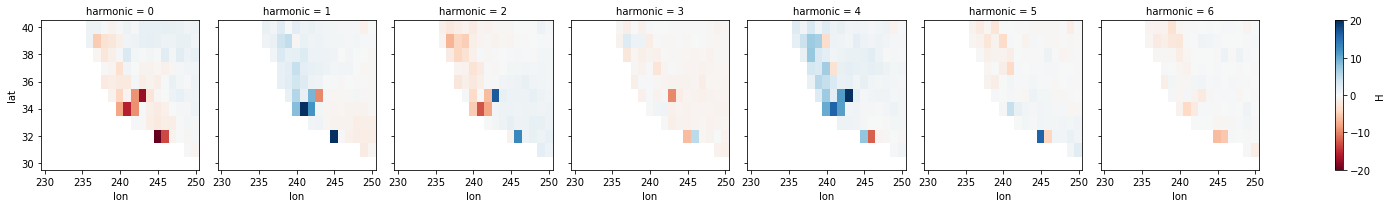

<Figure size 432x288 with 0 Axes>

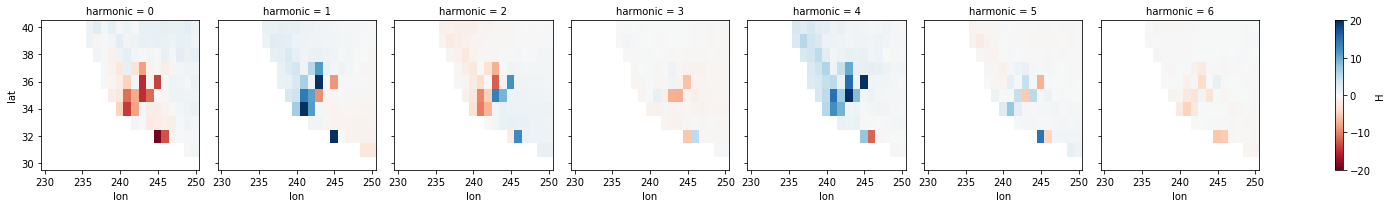

<Figure size 432x288 with 0 Axes>

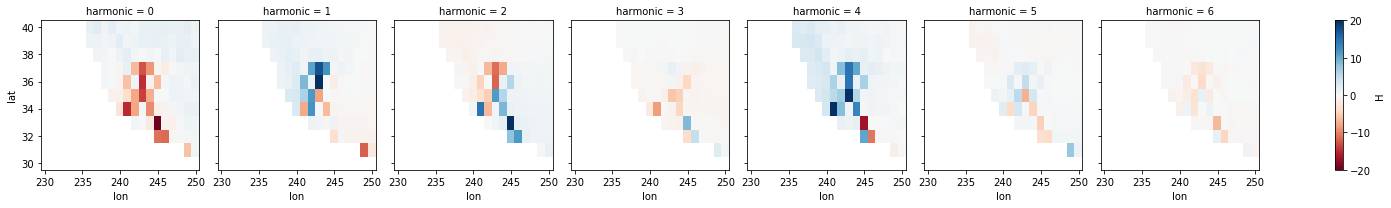

<Figure size 432x288 with 0 Axes>

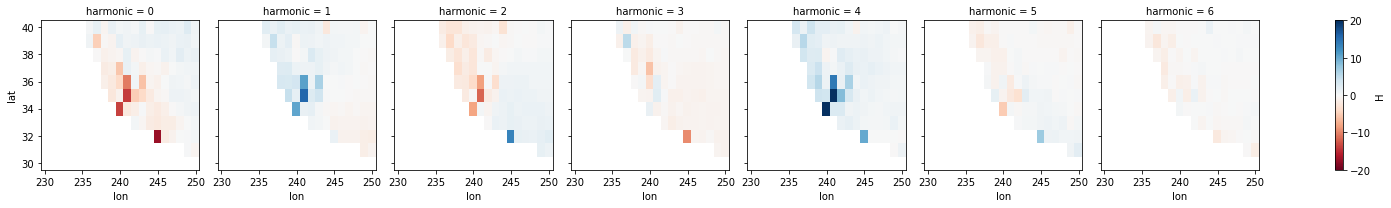

<Figure size 432x288 with 0 Axes>

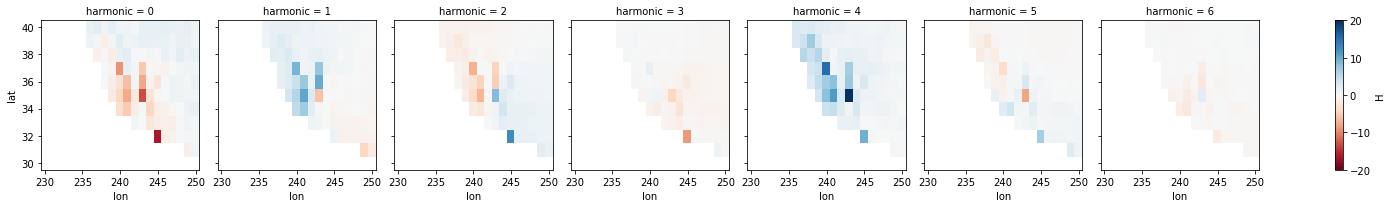

<Figure size 432x288 with 0 Axes>

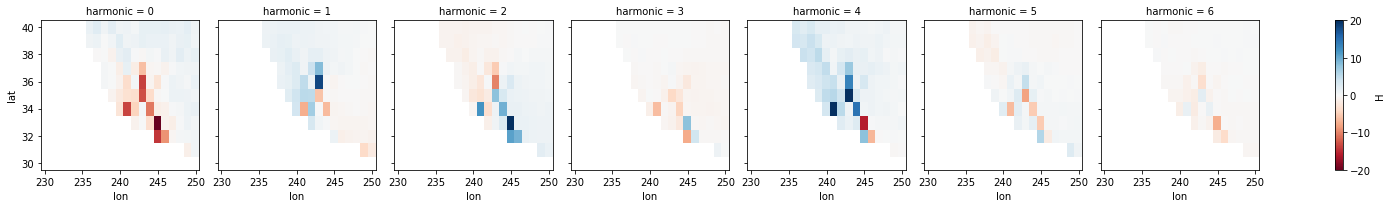

<Figure size 432x288 with 0 Axes>

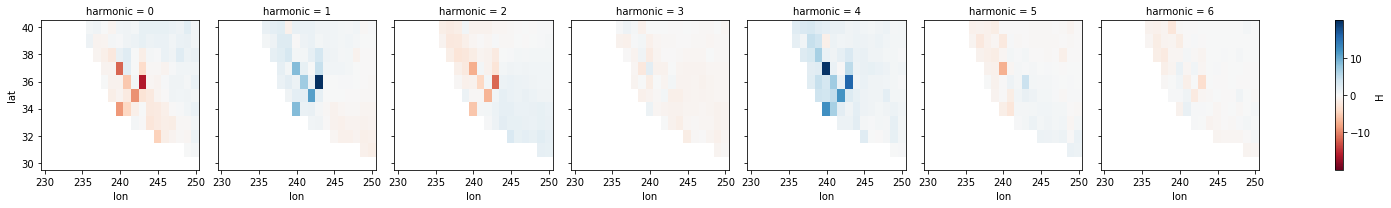

<Figure size 432x288 with 0 Axes>

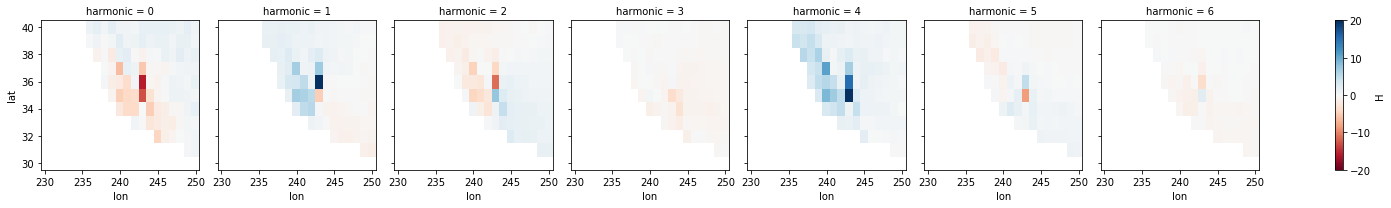

<Figure size 432x288 with 0 Axes>

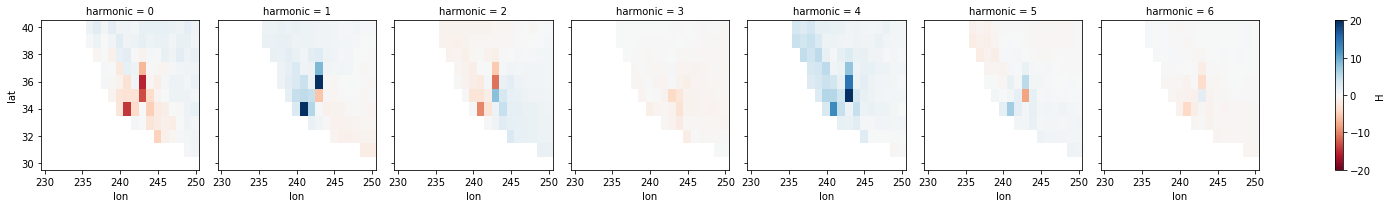

<Figure size 432x288 with 0 Axes>

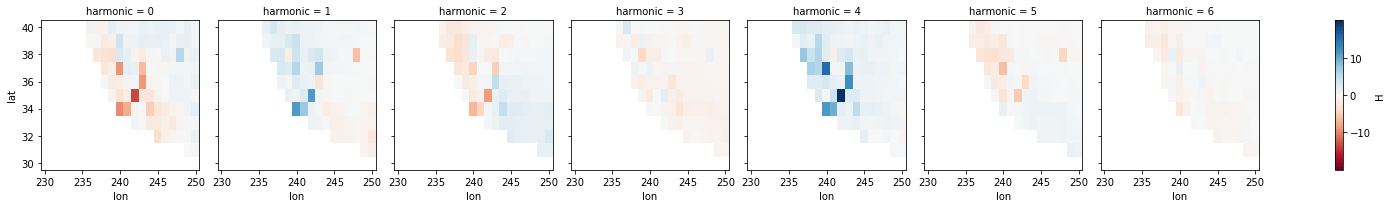

<Figure size 432x288 with 0 Axes>

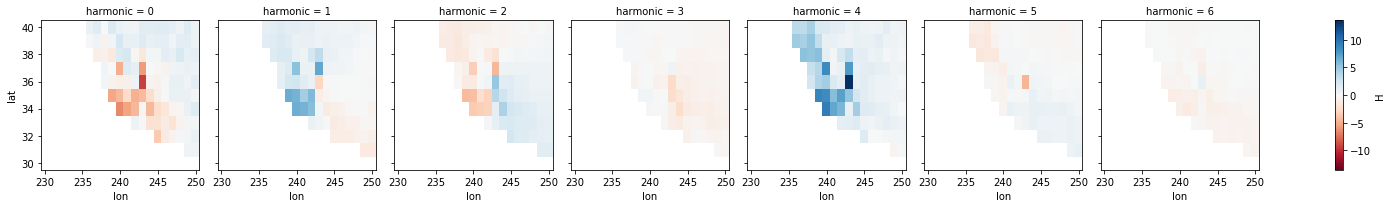

<Figure size 432x288 with 0 Axes>

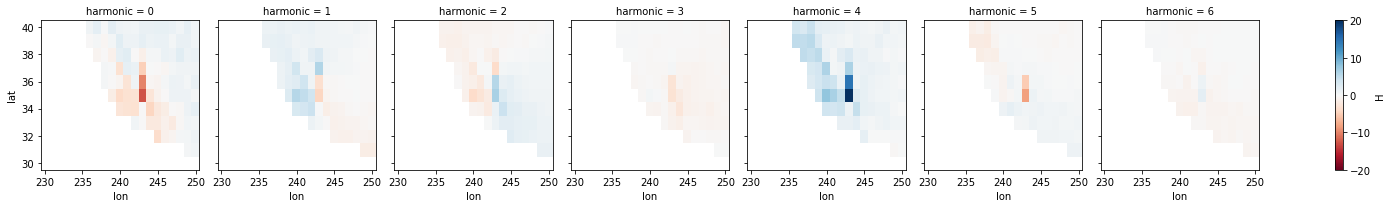

In [448]:
for Li in np.arange(0,4):
    plt.figure()
    trend_unstacked.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
    plt.figure()
    trend_unstacked3.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
    plt.figure()
    trend_unstacked2.H[:,Li].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')
    
    

In [329]:
trend_unstacked.H

<xarray.DataArray 'H' (harmonic: 7, Lbeg: 4, lat: 28, lon: 71)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan,

In [334]:
stacked = ds_clim_test_3d_all.sel(lat=slice(40,30), lon=slice(230,249), quantile=0.85).where(ds_mask.the_geom>0).stack(allpoints=['Lbeg','lat','lon'])  
trend = stacked.groupby('allpoints').apply(apply_fit_curve)
trend_unstacked = trend.unstack('allpoints')
trend_unstacked = trend_unstacked.rename({'allpoints_level_0':'Lbeg',
                                          'allpoints_level_1':'lat',
                                         'allpoints_level_2':'lon'})
trend_unstacked = trend_unstacked.to_dataset(name='H')
trend_unstacked.coords['target_clim'] = 'target_clim', stacked.target_clim.values


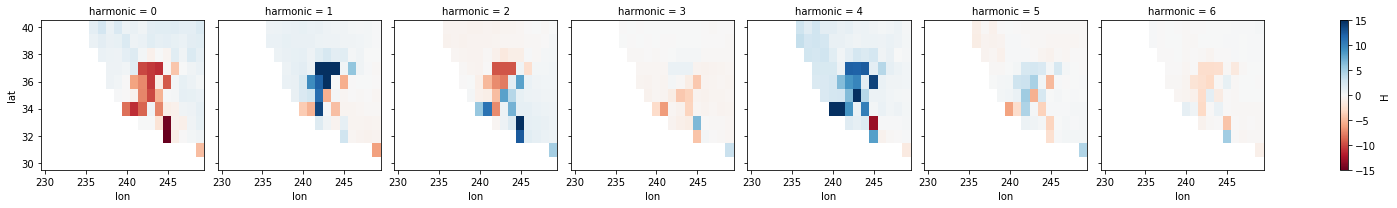

In [345]:
trend_unstacked.H[:,0].where(ds_mask.the_geom>0).plot(col='harmonic', cmap='RdBu')

local [-7.33506394 11.4107457  -4.66187975 -1.15892368  6.53563509  5.31788914
 -2.73822682]
local [-7.2490489  12.2867822  -7.04027428  0.28026951  8.84403209  3.18364758
 -2.39804214]


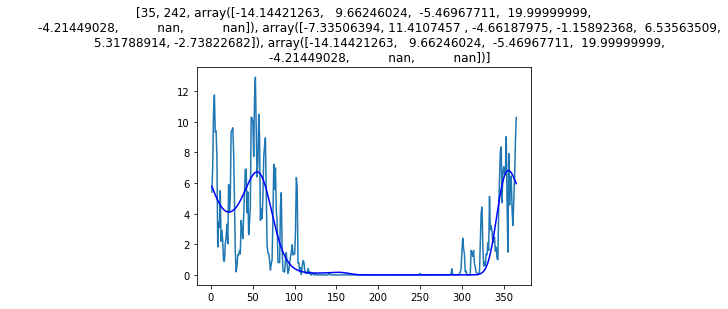

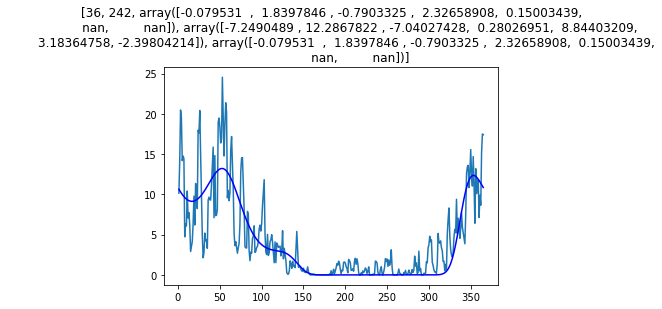

In [414]:
poptold  = [1]*7
# for ilat in np.arange(30,40):
#     for ilon in np.arange(230, 250):
for ilat in np.arange(35,37):
    for ilon in np.arange(242, 243):
        y = ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc.sel(lat=ilat, lon=ilon)[:,0,-1].values
        if np.sum(np.isnan(y))==len(y):
            print('',)
        else:
            poptold = trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,0].values
            x = ds_clim_test_3d_all.target_clim.dt.dayofyear.values
            popt, pcov = curve_fit(fffourierB, x,y, [0]*7, bounds=[-20,20])
#             popt1, pcov = curve_fit(fffourierB, x,y, poptold, bounds=[-20,20])
            print('local',popt)     
            popt5 = trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,0].values
#             print('diff',popt-popt5) 
            plt.figure()
            plt.plot(x,y)
            plt.plot(x,fffourierB(x,  *popt) , 'b')
            plt.plot(x,fffourierB(x,  *poptold) , 'm')
            plt.plot(x,fffourierB(x,  *popt5), 'r' )
            plt.title([ilat,ilon, popt5, popt, poptold])
            poptold = popt1*1
























































[-3.57204392 -0.916696    2.44737287 -0.76549753  1.86750094  0.91653815
 -0.62671025]
32 245 [-20.           4.92538931  17.59368126  -6.15206542  10.34846054
  -2.80507333   7.47702284]
[-19.2115352   19.99999812  -1.5489353   -5.38327607   7.70762189
  14.66082637  -5.31599719] [-20.          19.99954866  -0.90062764  -6.23017839   7.85478068
  16.19733609  -6.22954985] [-20.          19.99954866  -0.90062764  -6.23017839   7.85478068
  16.19733609  -6.22954985]






















[-7.46281693  7.45311148 -4.21246506  0.04611864  9.74217501 -0.10432809
 -0.81589595]
34 241 [-13.55056427  -7.39226467  12.37734717  -6.43412645  20.
  -6.26976087   1.70086881]
[-14.02402492  19.99999966 -10.16127274  -0.86622914  12.32443884
   7.63846006  -4.53452221] [-15.59823668  20.         -12.52383208   0.68042619  16.11991016
   4.67215627  -3.9808605 ] [-15.59823668  20.         -12.52383208   0.68042619  16.11991016
   4.67215627  -3.98

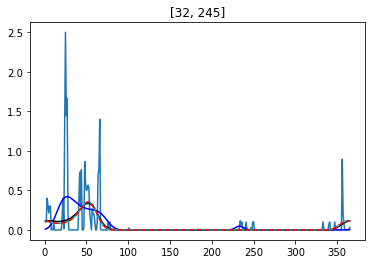

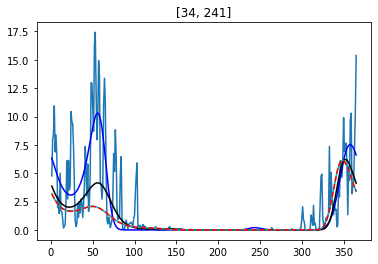

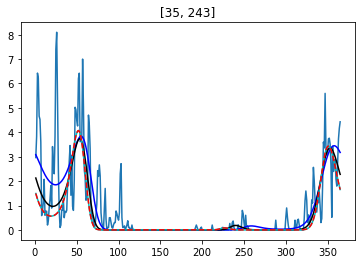

In [443]:
# poptold  = [1]*7
for ilat in np.arange(30,40):
    for ilon in np.arange(230, 250):
# for ilat in np.arange(34,35):
#     for ilon in np.arange(241, 242):
        y1 = ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc.sel(lat=ilat, lon=ilon)[:,0,-1].values
#         y2 = ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc.sel(lat=34, lon=241)[:,1,-1].values
#         y3 = ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc.sel(lat=34, lon=241)[:,2,-1].values
#         y4 = ds_clim_test_3d_all.where(ds_mask.the_geom>0).pr_sfc.sel(lat=34, lon=241)[:,3,-1].values
        y = y1*1#0.4+y2*0.3+y3*0.2+y4*0.1
        if np.sum(np.isnan(y))==len(y):
            print('',)
            
        else:
            poptold = trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,3].values
            if any(trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,0].values>15):
                x = ds_clim_test_3d_all.target_clim.dt.dayofyear.values
                print(poptold)
                popt, pcov = curve_fit(fffourierB, x,y, [0]*7, bounds=[-20,20])
                popt1, pcov = curve_fit(fffourierB, x,y, [0]*7, bounds=[-20,20], loss='cauchy')
                popt2, pcov = curve_fit(fffourierB, x,y, [0]*7, bounds=[-20,20], loss='arctan')
    #             print('local',popt)     
                popt5 = trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,0].values
    #             print('diff',popt-popt5) 
                plt.figure()
                plt.plot(x,y)
                plt.plot(x,fffourierB(x,  *popt) , 'b')
                plt.plot(x,fffourierB(x,  *popt1) , 'k')
                plt.plot(x,fffourierB(x,  *popt2) , 'c')
    #             plt.plot(x,fffourierB(x,  *poptold) , 'm--')
                plt.plot(x,fffourierB(x,  *popt5), 'r--' )
                plt.title([ilat,ilon])
                poptold = popt1*1
                print(ilat,ilon,popt)
                print(popt1,popt2, popt5)


In [358]:
            print(popt)
for ilat in np.arange(31,39):
    for ilon in np.arange(238, 247):
        y = ds_clim_test_3d_all.pr_sfc.sel(lat=ilat, lon=ilon)[:,3,-1].values
        if np.sum(np.isnan(y))==len(y):
            print(ilat, ilon, 'empty')
        else:
            popt5 = trend_unstacked.H.sel(lat=ilat, lon=ilon)[:,0,3].values
            if np.abs(popt5[0])>10:
#             print(y)
                y[y<0]=0

                x = ds_clim_test_3d_all.target_clim.dt.dayofyear.values


                # x = np.concatenate((x[290:]-365,x,x[:100]+365))
                # y =  np.concatenate((y[290:],y,y[:100]))
                popt, pcov = curve_fit(fffourierB, x,y, [-10]*7)
                print(popt)
                plt.figure()
                plt.plot(x,y)
                plt.plot(x,fffourierB(x,  *popt) , 'b')
                plt.plot(x,fffourierB(x,  *popt5), 'r' )
                plt.title([ilat,ilon, popt5, popt])

IndexError: too many indices

In [134]:
ds_clim_test_3d_all.pr_sfc[:,:,-1,:,:].sel(lat=34, lon=239)

<xarray.DataArray 'pr_sfc' (target_clim: 365, Lbeg: 4)>
array([[ 9.11999955, 11.02499981,  5.95999956,  6.27499981],
       [13.81500025, 14.72999992, 12.95849972,  8.3599998 ],
       [14.32500033, 12.4650002 , 14.04300013,  9.65      ],
       ...,
       [12.5235003 , 13.66499972, 11.74050016,  8.96499987],
       [14.53000045,  6.23499951, 10.44299984, 11.81500268],
       [13.80000033, 10.85500202,  9.54999962, 13.38000054]])
Coordinates:
    lon          float32 239.0
    lat          float32 34.0
  * Lbeg         (Lbeg) int64 2 4 6 8
    quantile     float64 0.85
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31

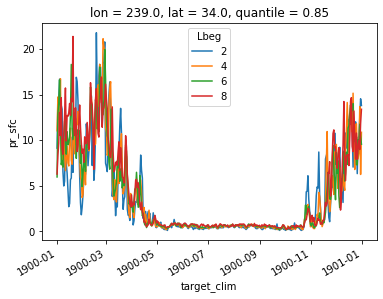

In [132]:
ds_clim_test_3d_all.pr_sfc[:,:,-1,:,:].sel(lat=34, lon=239).plot.line(x='target_clim')

In [240]:
trend_unstacked.to_netcdf('harmonics_from_quantiles.nc')

# Rebuild data based on coefficients

In [55]:
stack1 = trend_unstacked.stack(allpoints=['quant','Lbeg','lat','lon'])  
smooth_clim = stack1.groupby('allpoints').apply(apply_fffourier)
smooth_clim = smooth_clim.unstack('allpoints')
smooth_clim = smooth_clim.rename({'dim_0':'target_clim'})

smooth_clim.coords['target_clim'] = 'target_clim',stacked.target_clim.values

smooth_clim = smooth_clim.to_dataset(name='pr_sfc')

In [58]:
ds_clim_test_3d_all

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, quantile: 5, target_clim: 365)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * Lbeg         (Lbeg) int64 2 4 6 8
  * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, Lbeg, quantile, lat, lon) float64 2.3 ... 12.7

# Plot data and reconstructed climatologies

In [111]:
stack1.H.sel(lat=34, lon=239)

<xarray.DataArray 'H' (harmonic: 5, allpoints: 12)>
array([[-105.46774026, -112.19668669,  -90.33381386,  -75.29692486,
         -60.14754416,  -52.11784124,  -54.21203908,  -15.0181121 ,
          -3.81617812,   -5.37651903,   -3.13329273,   -1.89715491],
       [  46.72722084,   58.47082024,   49.29369508,   42.43932555,
          28.72360827,   27.164381  ,   30.75883142,    7.66660012,
           3.06077421,    3.97266779,    3.04577366,    2.32835945],
       [ -25.8790203 ,  -30.47050827,  -25.33072932,  -21.82705806,
         -15.75619104,  -14.44055764,  -15.93292604,   -3.86495811,
          -1.58679975,   -2.07538923,   -1.41561704,   -1.01462073],
       [ 138.35735946,  142.54639256,  113.33106489,   94.01901298,
          80.35955439,   68.6614557 ,   70.05352477,   20.59377091,
           7.97064722,   10.0310037 ,    6.84337422,    5.32819874],
       [ -35.04202065,  -32.38209257,  -24.9182845 ,  -20.48481713,
         -19.87689874,  -16.1172081 ,  -15.31641444,   -5.25

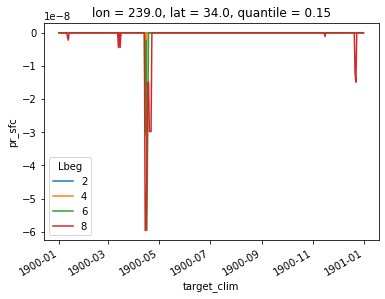

In [115]:
# smooth_clim.pr_sfc[:,0,:,:,:].sel(lat=34, lon=239).plot.line(x='target_clim')
ds_clim_test_3d_all.pr_sfc[:,:,0,:,:].sel(lat=34, lon=239).plot.line(x='target_clim')

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


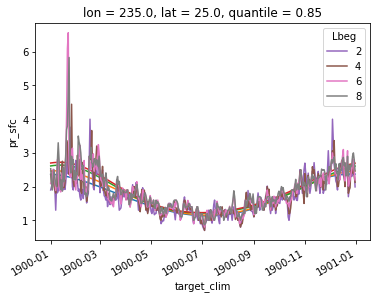

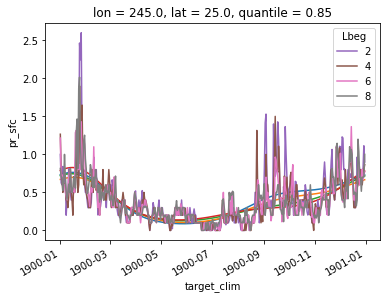

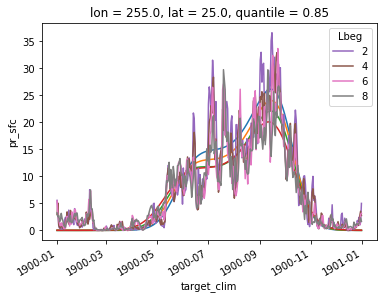

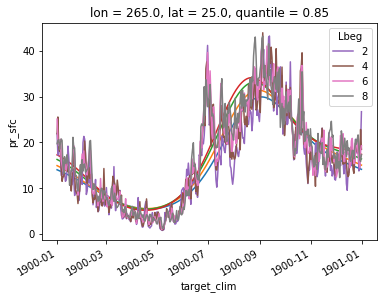

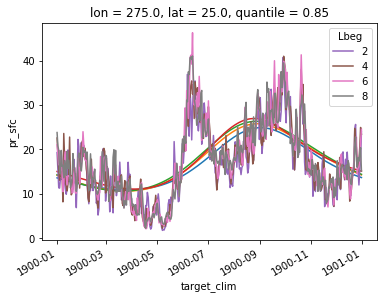

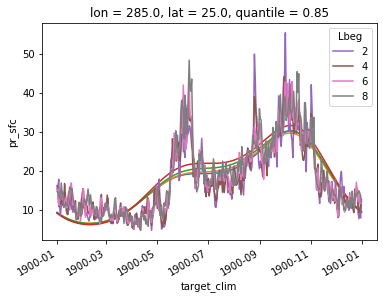

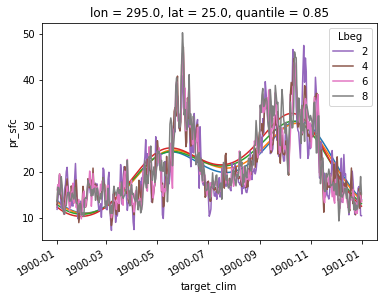

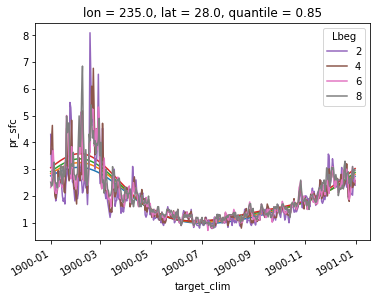

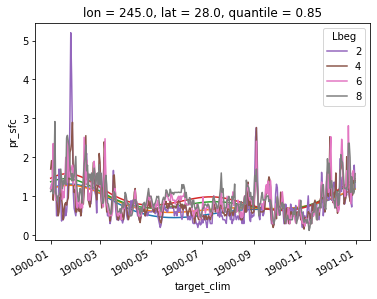

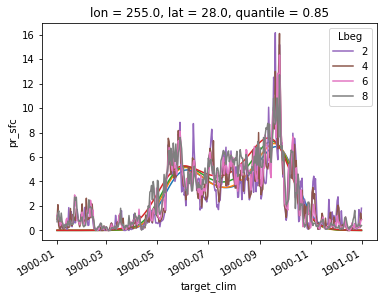

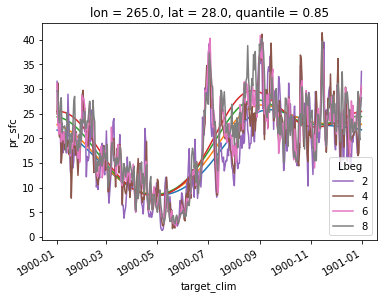

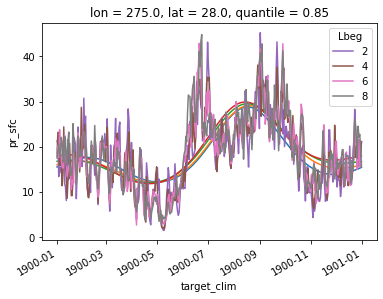

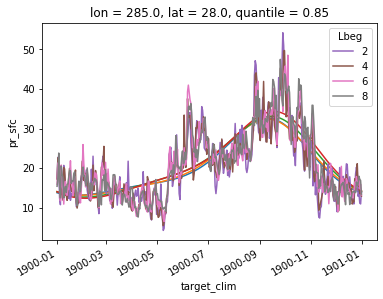

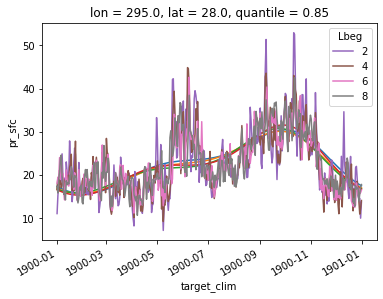

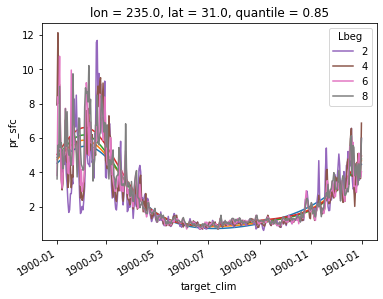

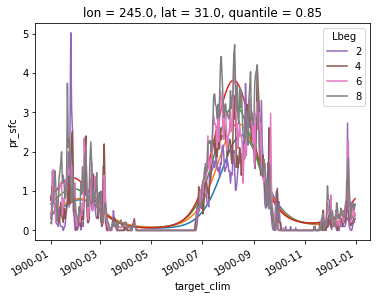

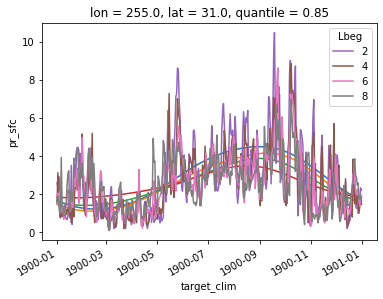

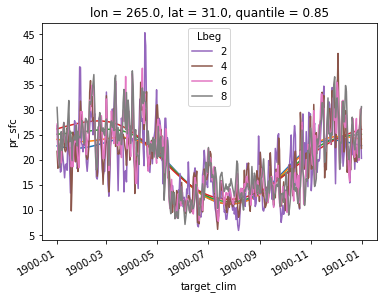

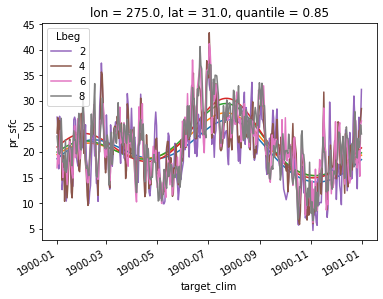

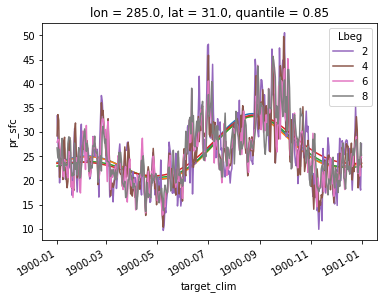

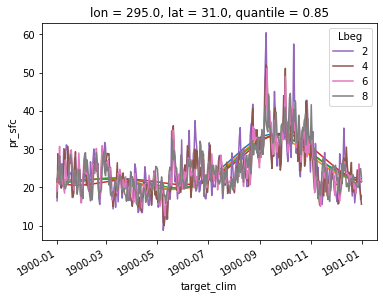

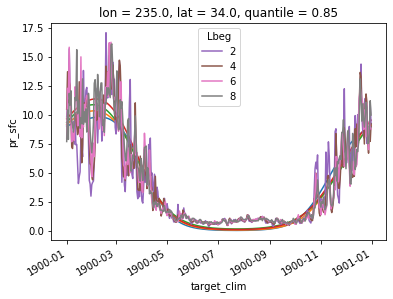

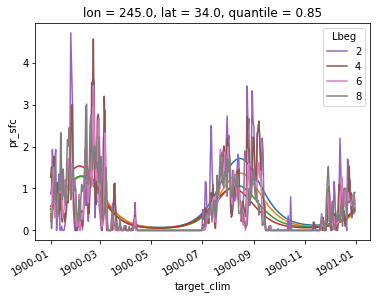

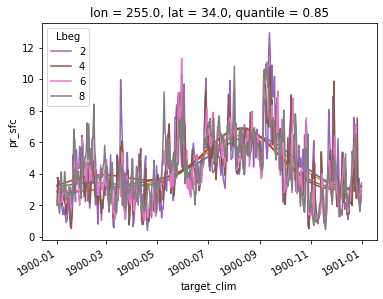

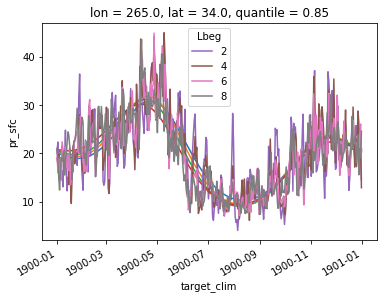

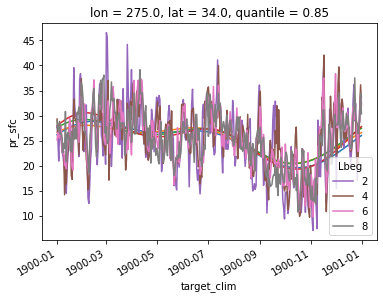

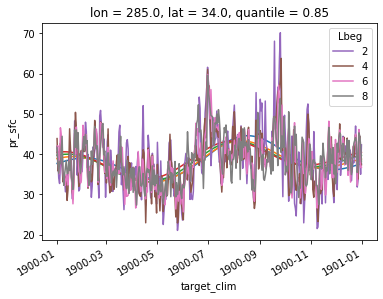

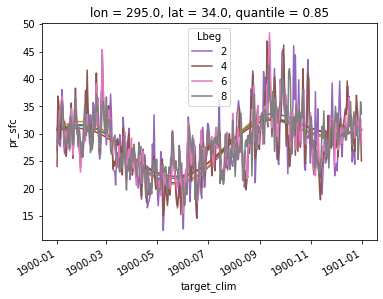

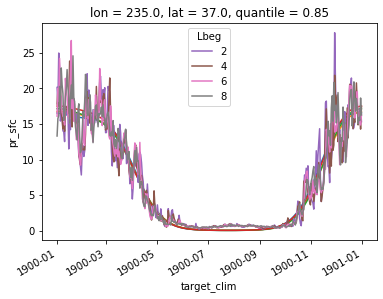

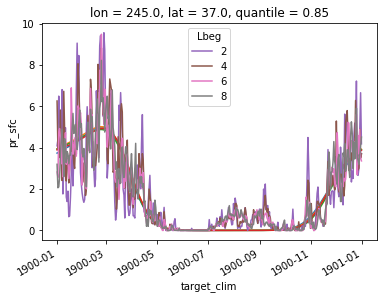

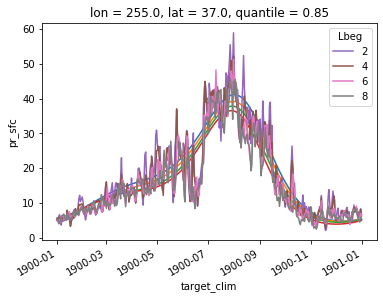

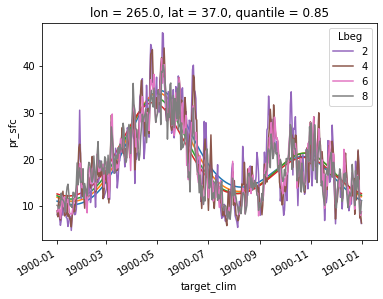

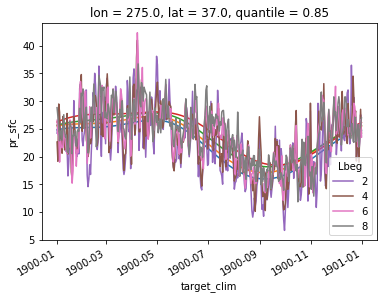

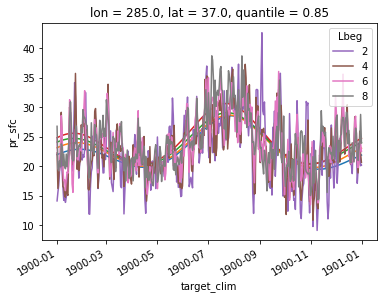

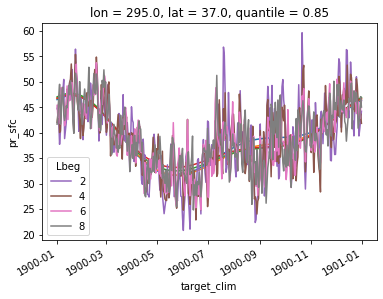

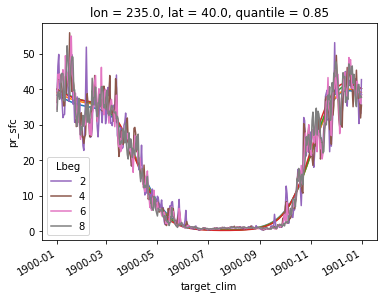

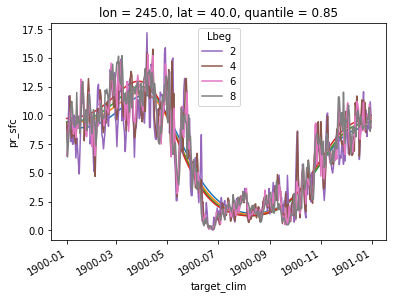

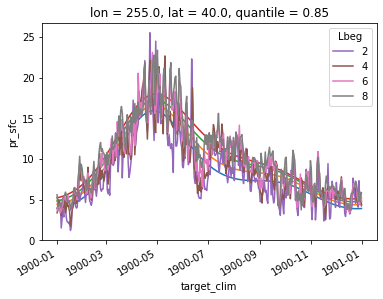

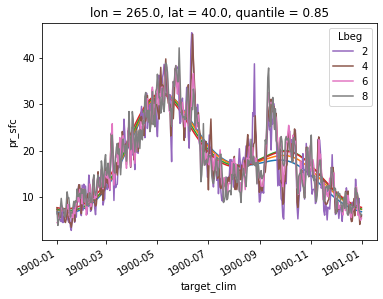

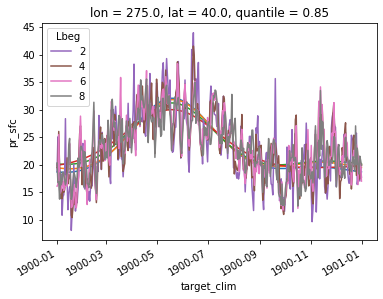

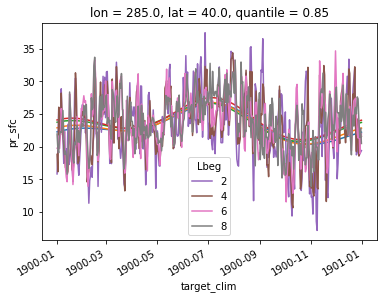

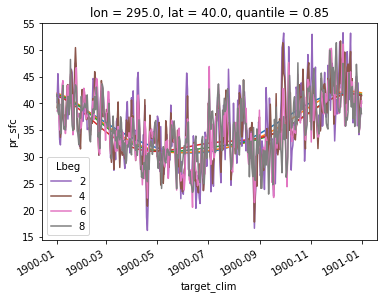

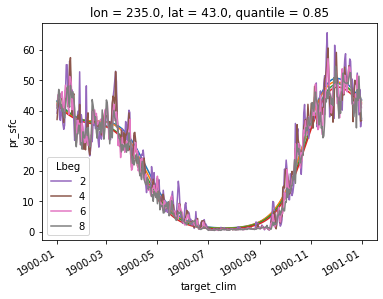

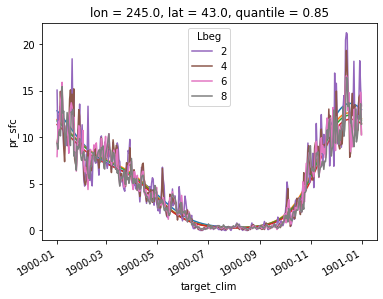

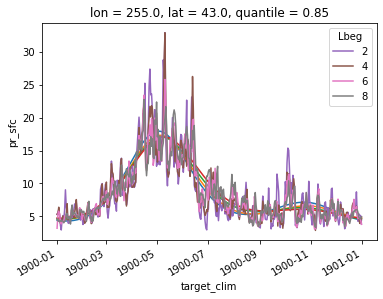

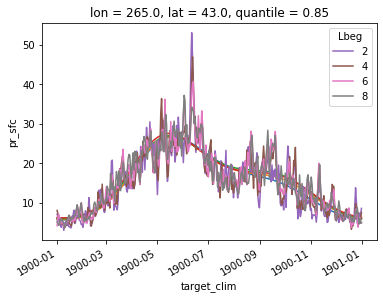

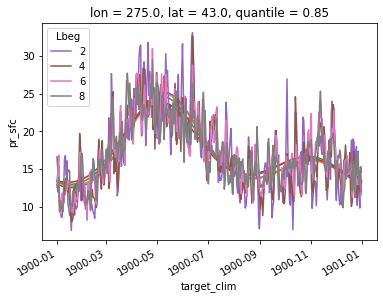

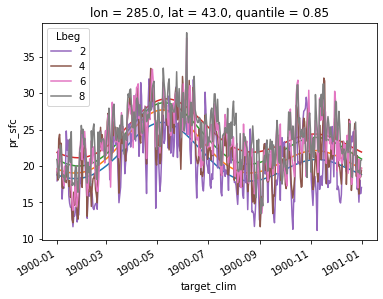

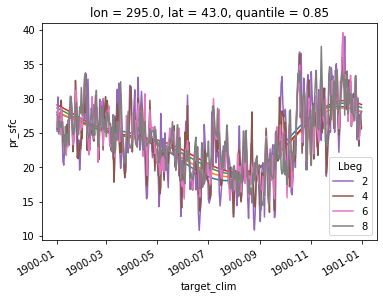

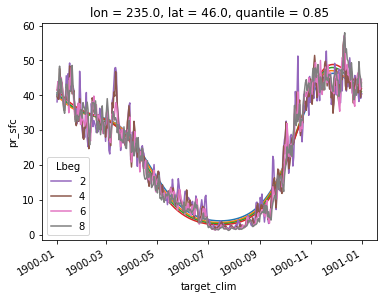

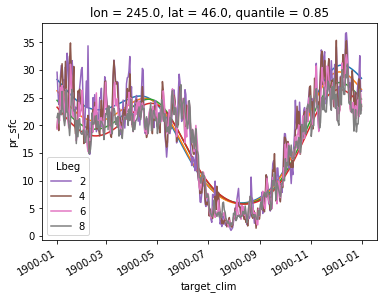

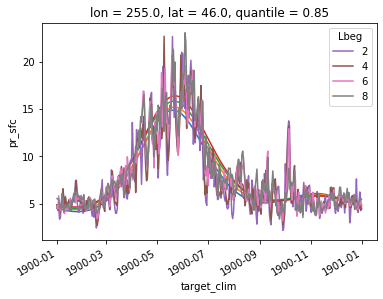

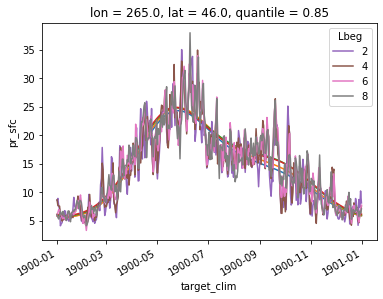

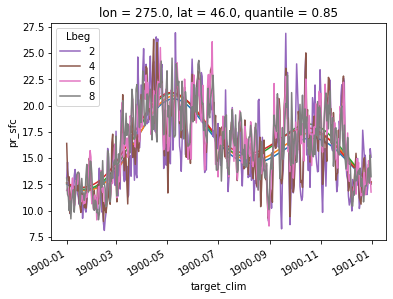

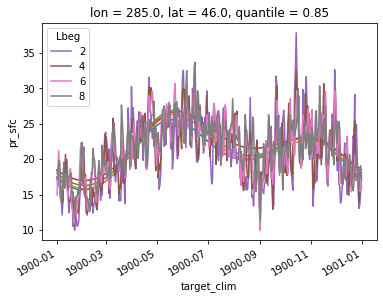

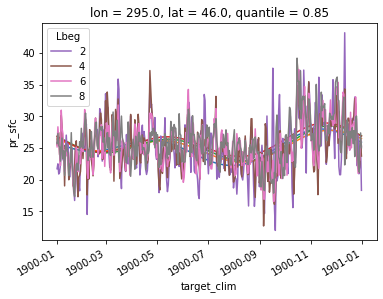

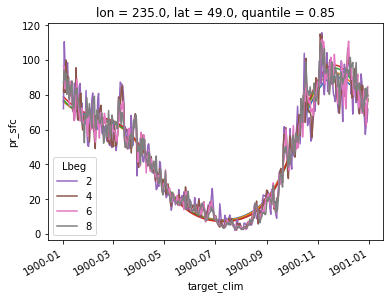

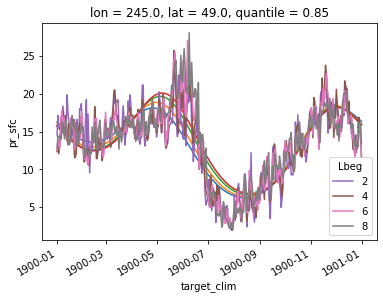

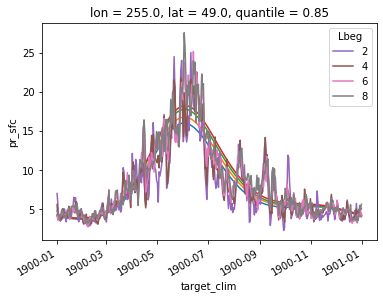

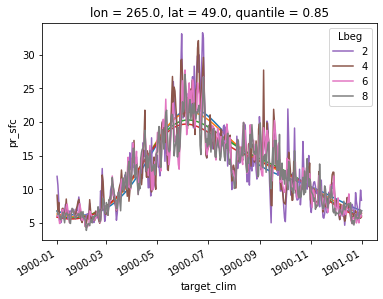

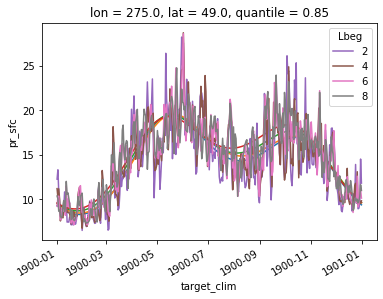

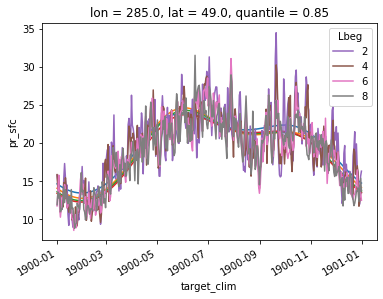

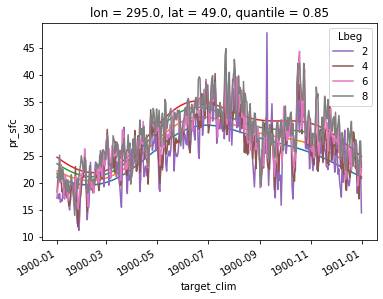

In [59]:
for ilat in np.arange(25,51,3):
    for ilon in np.arange(235,301,10):
        plt.figure()
        smooth_clim.pr_sfc[:,-1,:,:,:].sel(lat=ilat, lon=ilon).plot.line(x='target_clim')
        ds_clim_test_3d_all.pr_sfc[:,:,-1,:,:].sel(lat=ilat, lon=ilon).plot.line(x='target_clim')

In [60]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [73]:
def apply_smf_qr(dsin):
    tau = 365.25
#     quantiles = np.array([0.15,0.33,0.5,0.667,0.85])
    quantiles = np.array([0.85])

    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in dsin.St.values]
    y_arr = np.array(y_ls)
    
    ls_Lbeg = []
    
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = dsin.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))

        doy = np.tile(temp2.target_time.dt.dayofyear.values,10)
        intensity = temp2.pr_sfc.values.flatten()
# #         intensity[intensity==0]=1
        lintensity = np.log(intensity)
        minvalue = np.min(lintensity[np.isfinite(lintensity)])
        lintensity[np.isfinite(lintensity)==0]=minvalue-0.01
        print(lintensity)
        a = pd.DataFrame(lintensity, columns=['rain'])
        b = pd.DataFrame(doy, columns=['doy'])

        
        nu = 2*np.pi/tau
        harmonic1 = np.sin(1* nu * b)
        harmonic1 =harmonic1.rename(columns = {'doy':'h1'})        
        harmonic2 = np.cos(1* nu * b)
        harmonic2 =harmonic2.rename(columns = {'doy':'h2'})
        
        harmonic3 = np.sin(2* nu * b)
        harmonic3 =harmonic3.rename(columns = {'doy':'h3'})        
        harmonic4 = np.cos(2* nu * b)
        harmonic4 =harmonic4.rename(columns = {'doy':'h4'})
        
        harmonic5 = np.sin(3* nu * b)
        harmonic5 =harmonic5.rename(columns = {'doy':'h5'})        
        harmonic6 = np.cos(3* nu * b)
        harmonic6 =harmonic6.rename(columns = {'doy':'h6'})

        harmonic7 = np.sin(4* nu * b)
        harmonic7 =harmonic7.rename(columns = {'doy':'h7'})        
        harmonic8 = np.cos(4* nu * b)
        harmonic8 =harmonic8.rename(columns = {'doy':'h8'})
#generate the dataframe
#         data = pd.concat([a,b,np.exp(harmonic1),np.exp(harmonic2), np.exp(harmonic3), np.exp(harmonic4),
#                           np.exp(harmonic5),np.exp(harmonic6), np.exp(harmonic7), np.exp(harmonic8)  ], axis=1)
        data = pd.concat([a,b,harmonic1,harmonic2,harmonic3,harmonic4,
                          harmonic5,harmonic6,harmonic7,harmonic8  ], axis=1)
        modqr = smf.quantreg('rain ~ h1+h2+h3+h4', data) #+h5+h6+h7+h8 
#         modqr = smf.quantreg('rain ~ np.exp(h1)+np.exp(h2)+np.exp(h3)+np.exp(h4)', data)#*np.exp(h5)*np.exp(h6)*np.exp(h7)*np.exp(h8) ', data)
        
        ls_iquant =[]
        for iq in quantiles:
            res = modqr.fit(q=iq,max_iter=2000)
            print(res.summary())
            values = np.asarray([ res.params['Intercept'], 
                               res.params['h1'],  res.params['h2'], res.params['h3'], res.params['h4'] ])#,
#                                 res.params['h5'],  res.params['h6'], res.params['h7'], res.params['h8']] )
            ls_iquant.append(values)
        vda = xr.DataArray(np.asarray(ls_iquant), 
                           dims=['quant','harmonic'], coords=[quantiles,np.arange(0,5)])
        vda = vda.expand_dims('Lbeg')
        vda.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
        vda = vda.to_dataset(name='Harmonic')
        ls_Lbeg.append(vda)

    out = xr.combine_by_coords(ls_Lbeg)
    return  out
def exp_sum(*hin):
    return np.cumsum(hin)

    

In [74]:
all_variables_T3

<xarray.Dataset>
Dimensions:      (M: 10, lat: 28, lon: 71, target_time: 30987)
Coordinates:
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * target_time  (target_time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (target_time) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
Data variables:
    pr_sfc       (M, lat, lon, target_time) float32 10.5 38.1 ... 1.0199976

In [75]:
temp = all_variables_T3.sel(lat=slice(38,37), lon=slice(240, 241)).stack(allpoints=['lat','lon']) 
# temp = all_variables_T3.stack(allpoints=['lat','lon']) 

out = temp.groupby('allpoints').apply(apply_smf_qr)

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


[-18.724974  -18.724974  -18.724974  ...   4.5988503   3.7835076
   1.3001912]


/local/ERAin/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:192: IterationLimitWarning: Maximum number of iterations (2000) reached.
  ") reached.", IterationLimitWarning)


                         QuantReg Regression Results                          
Dep. Variable:                   rain   Pseudo R-squared:               0.3112
Model:                       QuantReg   Bandwidth:                      0.8238
Method:                 Least Squares   Sparsity:                        8.508
Date:                Sat, 27 Jun 2020   No. Observations:                75120
Time:                        17:54:40   Df Residuals:                    75115
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7722      0.011   -428.542      0.000      -4.794      -4.750
h1             5.2543      0.016    334.203      0.000       5.223       5.285
h2             9.5378      0.016    604.623      0.000       9.507       9.569
h3            -2.6985      0.017   -161.224      0.0

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


[ -2.3025851 -19.418121  -19.418121  ...   3.0184717   1.4724717
   0.7701076]
                         QuantReg Regression Results                          
Dep. Variable:                   rain   Pseudo R-squared:              0.01896
Model:                       QuantReg   Bandwidth:                      0.9471
Method:                 Least Squares   Sparsity:                        9.887
Date:                Sat, 27 Jun 2020   No. Observations:                75120
Time:                        17:54:48   Df Residuals:                    75115
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.7093      0.013    132.690      0.000       1.684       1.735
h1             0.8742      0.018     47.989      0.000       0.838       0.910
h2             0.8196      0.018     44.983      0.0

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


[-19.418121  -19.418121  -19.418121  ...   4.534533    3.5857384
   2.3204246]
                         QuantReg Regression Results                          
Dep. Variable:                   rain   Pseudo R-squared:              0.06214
Model:                       QuantReg   Bandwidth:                      0.9556
Method:                 Least Squares   Sparsity:                        11.39
Date:                Sat, 27 Jun 2020   No. Observations:                75120
Time:                        17:54:55   Df Residuals:                    75115
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9716      0.015     65.480      0.000       0.942       1.001
h1             1.8556      0.021     88.443      0.000       1.814       1.897
h2             2.4306      0.021    115.821      0.0

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


[ -1.2039728 -20.111269  -20.111269  ...   3.3311324   2.226783
   1.3787653]
                         QuantReg Regression Results                          
Dep. Variable:                   rain   Pseudo R-squared:              0.01682
Model:                       QuantReg   Bandwidth:                      0.9589
Method:                 Least Squares   Sparsity:                        7.661
Date:                Sat, 27 Jun 2020   No. Observations:                75120
Time:                        17:55:00   Df Residuals:                    75115
                                        Df Model:                            4
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9652      0.010    196.876      0.000       1.946       1.985
h1             0.8048      0.014     57.019      0.000       0.777       0.832
h2             0.5145      0.014     36.440      0.00

In [76]:
out

<xarray.Dataset>
Dimensions:            (Lbeg: 4, allpoints: 4, harmonic: 5, quant: 1)
Coordinates:
  * Lbeg               (Lbeg) int64 2 4 6 8
  * harmonic           (harmonic) int64 0 1 2 3 4
  * quant              (quant) float64 0.85
  * allpoints          (allpoints) MultiIndex
  - allpoints_level_0  (allpoints) float64 37.0 37.0 38.0 38.0
  - allpoints_level_1  (allpoints) float64 240.0 241.0 240.0 241.0
Data variables:
    Harmonic           (allpoints, Lbeg, quant, harmonic) float64 -4.772 ... 0.2094

In [77]:
out = out.unstack()


In [78]:
out

<xarray.Dataset>
Dimensions:            (Lbeg: 4, allpoints_level_0: 2, allpoints_level_1: 2, harmonic: 5, quant: 1)
Coordinates:
  * Lbeg               (Lbeg) int64 2 4 6 8
  * harmonic           (harmonic) int64 0 1 2 3 4
  * quant              (quant) float64 0.85
  * allpoints_level_0  (allpoints_level_0) float64 37.0 38.0
  * allpoints_level_1  (allpoints_level_1) float64 240.0 241.0
Data variables:
    Harmonic           (Lbeg, quant, harmonic, allpoints_level_0, allpoints_level_1) float64 -4.772 ... 0.2094

In [79]:
out.Harmonic[3,:,:,:,:]

<xarray.DataArray 'Harmonic' (quant: 1, harmonic: 5, allpoints_level_0: 2, allpoints_level_1: 2)>
array([[[[-6.33564122,  1.8041375 ],
         [ 1.8706772 ,  2.35640567]],

        [[ 4.98032876,  0.7817371 ],
         [ 1.11732447,  0.68855252]],

        [[ 9.84308838,  0.61170535],
         [ 1.33744397,  0.38707631]],

        [[-1.20549677,  0.02036859],
         [-0.38626044, -0.09504235]],

        [[-0.85984006,  0.23937617],
         [ 0.12079316,  0.20942553]]]])
Coordinates:
    Lbeg               int64 8
  * harmonic           (harmonic) int64 0 1 2 3 4
  * quant              (quant) float64 0.85
  * allpoints_level_0  (allpoints_level_0) float64 37.0 38.0
  * allpoints_level_1  (allpoints_level_1) float64 240.0 241.0

In [80]:
trend_unstacked

<xarray.Dataset>
Dimensions:      (Lbeg: 4, harmonic: 5, lat: 28, lon: 71, quant: 3, target_clim: 365)
Coordinates:
  * harmonic     (harmonic) int64 0 1 2 3 4
  * quant        (quant) float64 0.5 0.667 0.85
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    H            (harmonic, quant, Lbeg, lat, lon) float64 0.1125 ... -0.02311

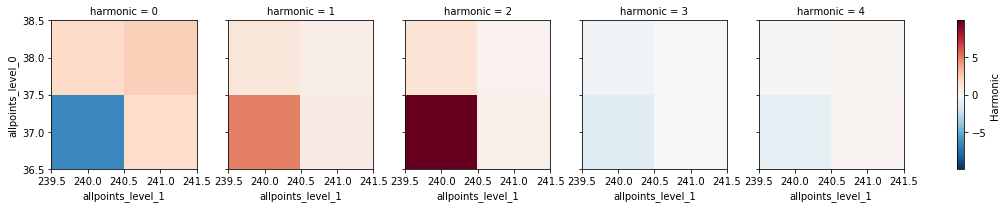

In [81]:
out1 = out.unstack()
out1.Harmonic[3,-1,:,:,:].plot(col='harmonic')

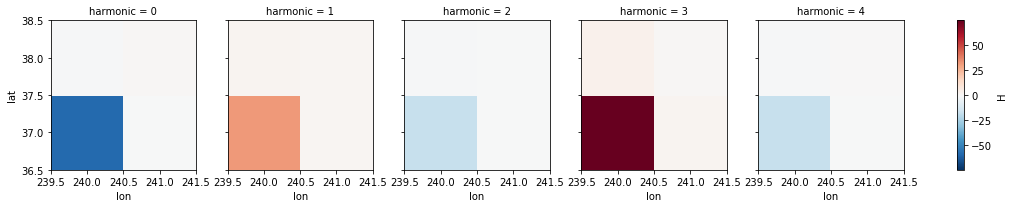

In [82]:
trend_unstacked.H.sel(lat=slice(37,38), lon=slice(240, 241))[0:5,-2,3].plot(col='harmonic')

In [83]:
out1 = out1.rename({'allpoints_level_0':'lat','allpoints_level_1':'lon'})

In [84]:
out1 = out1.rename({'Harmonic':'H'})

In [85]:
# (trend_unstacked.H.sel(lat=slice(37,38), lon=slice(240, 241))[0:5,-1,3].values-out1.H[3,-1,:,:,:]).plot(col='harmonic')

In [86]:
out1.coords['target_clim'] = 'target_clim', stacked.target_clim.values
stack2 = out1.stack(allpoints=['quant','Lbeg','lat','lon'])  
smooth_clim2 = stack2.groupby('allpoints').apply(apply_fffourierL)


smooth_clim2 = smooth_clim2.unstack('allpoints')

smooth_clim2 = smooth_clim2.rename({'dim_0':'target_clim'})

smooth_clim2.coords['target_clim'] = 'target_clim',stacked.target_clim.values

smooth_clim2 = smooth_clim2.to_dataset(name='pr_sfc')

In [87]:
smooth_clim2

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 2, lon: 2, quant: 1, target_clim: 365)
Coordinates:
  * quant        (quant) float64 0.85
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 37.0 38.0
  * lon          (lon) float64 240.0 241.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, quant, Lbeg, lat, lon) float64 0.0001569 ... 11.76

In [88]:
smooth_clim

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, quant: 3, target_clim: 365)
Coordinates:
  * quant        (quant) float64 0.5 0.667 0.85
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lat          (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon          (lon) float64 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-01 ... 1900-12-31
Data variables:
    pr_sfc       (target_clim, quant, Lbeg, lat, lon) float64 1.395 ... 26.19

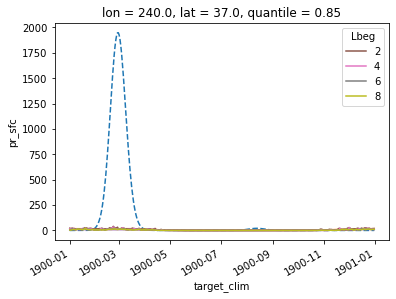

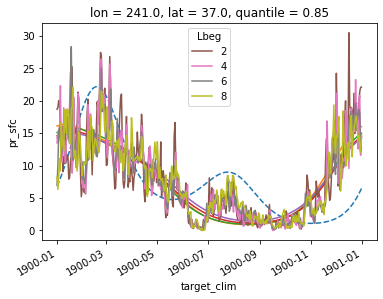

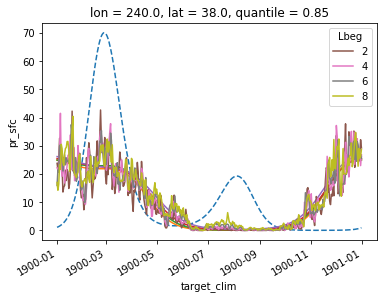

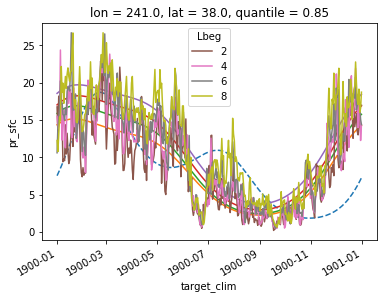

In [97]:
for ilat in np.array([37,38]):
    for ilon in np.array([240,241]):
        plt.figure()
        smooth_clim2.pr_sfc[:,-1,0,:].sel(lat=ilat, lon=ilon).plot.line('--',x='target_clim')
        smooth_clim.pr_sfc[:,-1,:,:].sel(lat=ilat, lon=ilon).plot.line(x='target_clim')
        ds_clim_test_3d_all.pr_sfc.isel(quantile=-1)[:,:,:,:].sel(lat=ilat, lon=ilon).plot.line(x='target_clim')

In [406]:
temp = all_variables_T3.stack(allpoints=['lat','lon']) 
for k,gp, in temp.groupby('allpoints'):
    print(k)
    print(gp)
    break

(23.0, 230.0)
<xarray.Dataset>
Dimensions:      (M: 10, allpoints: 1, target_time: 30987)
Coordinates:
  * M            (M) int64 0 1 2 3 4 5 6 7 8 9
  * target_time  (target_time) datetime64[ns] 1999-01-06T12:00:00 ... 2017-01-29T12:00:00
    St           (target_time) object (Timestamp('1999-01-06 00:00:00'), Timedelta('0 days 12:00:00')) ... (Timestamp('2016-12-28 00:00:00'), Timedelta('32 days 12:00:00'))
  * allpoints    (allpoints) MultiIndex
  - lat          (allpoints) float64 23.0
  - lon          (allpoints) float64 230.0
Data variables:
    pr_sfc       (M, target_time, allpoints) float32 0.1 0.1 ... 0.6799951


In [ ]:
mod = smf.quantreg('foodexp ~ income', data)
res = mod.fit(q=.5)

quantiles = np.arange(.05, .96, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['income']] + \
            res.conf_int().loc['income'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'lb', 'ub'])


In [ ]:
fffourier(x, *popt)

In [288]:
trend_unstacked

<xarray.Dataset>
Dimensions:   (Lbeg: 4, harmonic: 5, lat: 28, lon: 71)
Coordinates:
  * harmonic  (harmonic) int64 0 1 2 3 4
  * Lbeg      (Lbeg) int64 2 4 6 8
  * lat       (lat) float64 23.0 24.0 25.0 26.0 27.0 ... 47.0 48.0 49.0 50.0
  * lon       (lon) float64 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
Data variables:
    H         (harmonic, Lbeg, lat, lon) float64 3.907 3.716 ... -2.192 -1.788

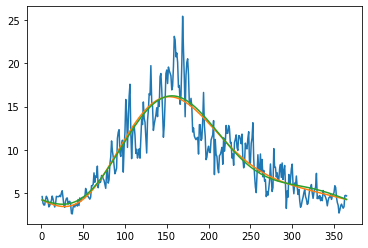

In [243]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
p1, = plt.plot(x, y)
p2, = plt.plot(x, 
               fffourier(x, *popt))
p2, = plt.plot(x, 
               fffourier(x, popt[0],popt[1],popt[2],popt[3],popt[4]))
# for ip in np.arange(2,5):


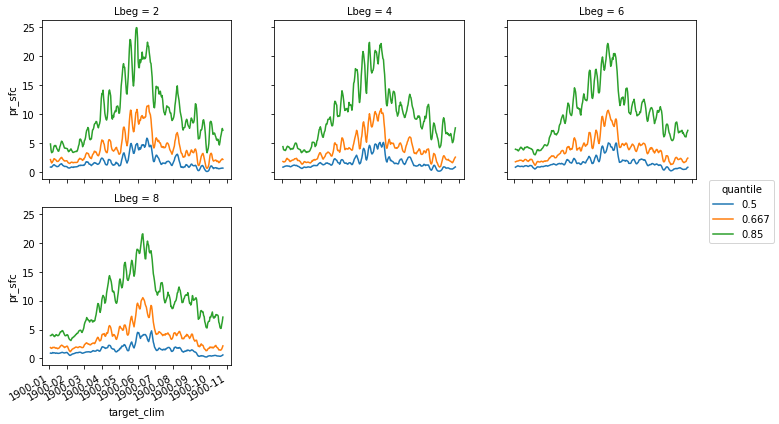

In [38]:
ds_clim_test_3d_all5.pr_sfc[:,:,-3:,2,30].plot.line(x='target_clim',col='Lbeg', col_wrap=3)

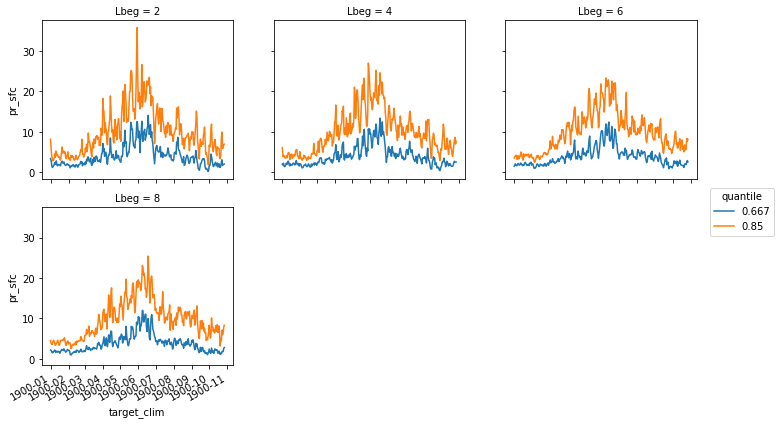

In [31]:
ds_clim_test_3d_all.pr_sfc[:,:,-2:,2,30].plot.line(x='target_clim',col='Lbeg', col_wrap=3)

In [19]:
narr_clim_test_3d = xr.open_dataset('narr_clim_test_3d.nc')
persiann_clim_test_3d = xr.open_dataset('persiann_clim_test_3d.nc')
cpc_clim_test_3d = xr.open_dataset('cpc_clim_test_3d.nc')
ds_clim_test_3d = xr.open_dataset('ds_clim_test_3d.nc')

In [20]:
ds_clim_test_3d

<xarray.Dataset>
Dimensions:      (Lbeg: 4, lat: 28, lon: 71, quant: 5, target_clim: 12)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quant        (quant) float64 0.15 0.33 0.5 0.667 0.85
  * Lbeg         (Lbeg) int64 2 4 6 8
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-15 ... 1900-12-15
Data variables:
    pr_sfc       (target_clim, Lbeg, quant, lat, lon) float64 ...

In [24]:
# looping through the target dates for climatologies
ds_clim_test_3d = []
for iT in target:
    # extract values that correspond to the target dates
    temp = all_variables_T3.where((all_variables_T3.target_time.dt.month==iT.month.values[0])&
                              (all_variables_T3.target_time.dt.day==iT.day.values[0]), drop=True)
    
    # bits to extract the S and t of each target_time
    y_ls = [y for (x,y) in temp.St.values]
    y_arr = np.array(y_ls)
    # loop through the 3 types of lead times
    # I have the -1 because of the way the timedelta is centered at 0 day and 12hours for day 1
#     for different_lead1, different_lead2 in zip(np.array([1,7,13])-1, np.array([5,11,17])-1 ):
    for different_lead1, different_lead2 in zip(np.array([2,4,6,8])-1, np.array([10,12,14,16])-1 ):
#         print(y_arr[(y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D'))])
        temp2 = temp.sel(target_time=
                         (y_arr>np.timedelta64(different_lead1,'D'))&(y_arr<np.timedelta64(different_lead2,'D')))
        temp3 = temp2.stack(Mtt=('M','target_time'))
#         print(temp3.pr_sfc.values.shape)
        temp3 = temp3.quantile(dim=['Mtt'], q=[0.15,0.33,0.5,0.667,0.85])
        temp3 = temp3.expand_dims('Lbeg')
        temp3.coords['Lbeg'] = 'Lbeg', np.atleast_1d(different_lead1+1)
#         print(temp3)
        if different_lead1==1:
            ds_quantile = temp3*1.
        else:
            ds_quantile = xr.merge([ds_quantile,temp3])
    ds_quantile = ds_quantile.expand_dims('target_clim')
    ds_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    ds_clim_test_3d.append(ds_quantile)
ds_clim_test_3d = xr.combine_by_coords(ds_clim_test_3d)    


In [25]:
ds_clim_test_3d = ds_clim_test_3d.rename({'quantile':'quant'})


In [106]:
ds_clim_test_3d.to_netcdf('ds_clim_test_3d.nc')

# PERSIANN DATA

In [130]:
persiann_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.CDR/.PERSIANN/.v01r01/.precipitation/Y/25/50/RANGE/X/230/300/RANGE/T/(1999)/(2016)/RANGEEDGES/dods')



In [131]:
persiann_ds = persiann_ds.rename({'T':'time','X':'lon','Y':'lat'})

In [134]:
persiann_ds

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1999-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    precipitation  (time, lon, lat) float32 2.5556662 1.9122274 ... 0.0 0.0
Attributes:
    Conventions:  IRIDL

In [144]:
persiann_ds = persiann_ds.transpose('time','lat','lon')
persiann_ds

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1999-01-01T12:00:00 ... 2016-12-31T12:00:00
Data variables:
    precipitation  (time, lat, lon) float32 2.5556662 2.1840682 ... 0.0 0.0
Attributes:
    Conventions:  IRIDL

In [145]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    *empty*

In [146]:
import xesmf as xe


In [147]:
temppersiann = persiann_ds.rolling(time=3, center=False).sum()
temppersiann.coords['time'] = temppersiann.time.values-np.timedelta64(2,'D')

In [148]:
temppersiann

<xarray.Dataset>
Dimensions:        (lat: 102, lon: 282, time: 6575)
Coordinates:
  * lat            (lat) float32 24.875 25.125 25.375 ... 49.625 49.875 50.125
  * lon            (lon) float32 229.875 230.125 230.375 ... 299.875 300.125
  * time           (time) datetime64[ns] 1998-12-30T12:00:00 ... 2016-12-29T12:00:00
Data variables:
    precipitation  (time, lat, lon) float32 nan nan nan ... 10.913296 13.459204

In [149]:
ds_out =ds_clim_test_3d[['lon','lat']]
ds_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71)
Coordinates:
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    *empty*

In [150]:
regridderp = xe.Regridder(temppersiann, ds_out, 'bilinear')
regridderp

Overwrite existing file: bilinear_102x282_28x71.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_102x282_28x71.nc 
Reuse pre-computed weights? False 
Input grid shape:           (102, 282) 
Output grid shape:          (28, 71) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [151]:
persiann_out = regridderp(temppersiann)


using dimensions ('lat', 'lon') from data variable precipitation as the horizontal dimensions for this dataset.


In [152]:
persiann_out

<xarray.Dataset>
Dimensions:        (lat: 28, lon: 71, time: 6575)
Coordinates:
  * time           (time) datetime64[ns] 1998-12-30T12:00:00 ... 2016-12-29T12:00:00
  * lon            (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * lat            (lat) float32 50.0 49.0 48.0 47.0 ... 26.0 25.0 24.0 23.0
Data variables:
    precipitation  (time, lat, lon) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [153]:
# looping through the target dates for climatologies
persiann_clim_test_3d = []
for iT in target:
    # extract values exact values
    temp = persiann_out.where((persiann_out.time.dt.month==iT.month.values[0])&
                        (persiann_out.time.dt.day==iT.day.values[0]), drop=True)
    temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    persiann_quantile = temp*1.
    persiann_quantile = persiann_quantile.expand_dims('window')
    persiann_quantile.coords['window'] = 'window', np.atleast_1d(1)
    # adding 2 days before and after
    temp1 = persiann_out.where((persiann_out.time.dt.month==iT.month.values[0])&
                        ((persiann_out.time.dt.day>=iT.day.values[0]-2)&(persiann_out.time.dt.day<=iT.day.values[0]+2)), 
                          drop=True)

    temp1 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    temp1 = temp1.expand_dims('window')
    temp1.coords['window'] = 'window', np.atleast_1d(5)
    persiann_quantile = xr.merge([persiann_quantile, temp1])
    persiann_quantile = persiann_quantile.expand_dims('target_clim')
    persiann_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    persiann_clim_test_3d.append(persiann_quantile)
persiann_clim_test_3d = xr.combine_by_coords(persiann_clim_test_3d)    


In [157]:
persiann_clim_test_3d = persiann_clim_test_3d.rename({'quantile':'quant'})


persiann_clim_test_3d = persiann_clim_test_3d.rename({'precipitation':'apcp'})


In [158]:
persiann_clim_test_3d.to_netcdf('persiann_clim_test_3d.nc')

# CPC

In [200]:
cpc1 = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.CONUS/.v1p0/.RETRO/.rain/Y/25/50/RANGE/T/(1999)/(2006)/RANGEEDGES/dods')
cpc2 = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.UNIFIED_PRCP/.GAUGE_BASED/.CONUS/.v1p0/.REALTIME/.rain/Y/25/50/RANGE/T/(2007)/(2016)/RANGEEDGES/dods')


In [201]:
cpc1 = cpc1.rename({'T':'time','X':'lon','Y':'lat'})
cpc2 = cpc2.rename({'T':'time','X':'lon','Y':'lat'})


In [202]:
cpc1.coords['lon'] = cpc1.lon.values+360
cpc2.coords['lon'] = cpc2.lon.values+360

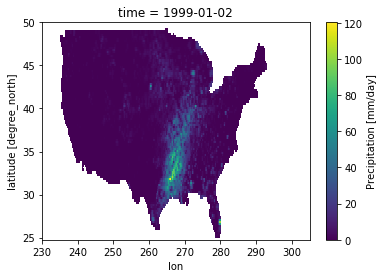

In [205]:
cpc1.rain[0].plot()

In [206]:
regridderc = xe.Regridder(cpc2, ds_out, 'bilinear')
regridderc

Create weight file: bilinear_101x300_28x71.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_101x300_28x71.nc 
Reuse pre-computed weights? False 
Input grid shape:           (101, 300) 
Output grid shape:          (28, 71) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

In [207]:
cpc1_out = regridderc(cpc1)
cpc2_out = regridderc(cpc2)


using dimensions ('lat', 'lon') from data variable rain as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable rain as the horizontal dimensions for this dataset.


In [208]:
cpc1_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 2921)
Coordinates:
  * time     (time) datetime64[ns] 1999-01-02 1999-01-03 ... 2006-12-31
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    rain     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    regrid_method:  bilinear

In [209]:
cpc_out = xr.combine_by_coords([cpc1_out, cpc2_out])

In [210]:
cpc_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 6573)
Coordinates:
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1999-01-02 1999-01-03 ... 2016-12-31
Data variables:
    rain     (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [211]:
cpc_out = cpc_out.rolling(time=3, center=False).sum()
cpc_out.coords['time'] = cpc_out.time.values-np.timedelta64(2,'D')

In [212]:
# looping through the target dates for climatologies
cpc_clim_test_3d = []
for iT in target:
    # extract values exact values
    temp = cpc_out.where((cpc_out.time.dt.month==iT.month.values[0])&
                        (cpc_out.time.dt.day==iT.day.values[0]), drop=True)
    temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    cpc_quantile = temp*1.
    cpc_quantile = cpc_quantile.expand_dims('window')
    cpc_quantile.coords['window'] = 'window', np.atleast_1d(1)
    # adding 2 days before and after
    temp1 = cpc_out.where((cpc_out.time.dt.month==iT.month.values[0])&
                        ((cpc_out.time.dt.day>=iT.day.values[0]-2)&(cpc_out.time.dt.day<=iT.day.values[0]+2)), 
                          drop=True)

    temp1 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    temp1 = temp1.expand_dims('window')
    temp1.coords['window'] = 'window', np.atleast_1d(5)
    cpc_quantile = xr.merge([cpc_quantile, temp1])
    cpc_quantile = cpc_quantile.expand_dims('target_clim')
    cpc_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    cpc_clim_test_3d.append(cpc_quantile)
cpc_clim_test_3d = xr.combine_by_coords(cpc_clim_test_3d)    


In [213]:
cpc_clim_test_3d = cpc_clim_test_3d.rename({'quantile':'quant'})


cpc_clim_test_3d = cpc_clim_test_3d.rename({'rain':'apcp'})


In [214]:
cpc_clim_test_3d.to_netcdf('cpc_clim_test_3d.nc')

# NARR data

In [26]:
narr_ls=[]
for iy in np.arange(1999, 2017):
    temp = xr.open_dataset('/crunch/c0/NARR/3_hr_all/apcp/apcp.'+np.str(iy)+'.nc',
                          drop_variables='Lambert_Conformal')
    # aggregate to daily
    temp = temp.resample(time='1D').sum()
#     print(temp)
#     pause
    narr_ls.append(temp)
    del temp

/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  use_cftime=use_cftime,
/local/ERAin/lib/python3.6/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'apcp' has multiple fill values {9.96921e+36, -9.

### combine, roll sum, roll back startign interval date

In [37]:
temp_latlon = narr_ls[0][['lat','lon']]
temp_latlon

<xarray.Dataset>
Dimensions:  (x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
Data variables:
    *empty*

In [38]:
narr_ds = xr.combine_by_coords(narr_ls)

### for some reason hte combining creates a dimension time for lon (might be small differences in decimal values). So I drop it and substitute with one only

In [40]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (time, y, x) float32 -145.5 -145.315 ... 357.35638 357.4301
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [41]:
narr_ds = narr_ds.drop('lon')

In [44]:
narr_ds.coords['lon']=temp_latlon.lon


In [45]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [46]:
tempnarr = narr_ds.rolling(time=3, center=False).sum()
tempnarr.coords['time'] = tempnarr.time.values-np.timedelta64(2,'D')

In [47]:
import xesmf as xe
tempnarr = tempnarr.drop(['x','y'])
ds_out =ds_clim_test_3d[['lat','lon']]

In [48]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71)
Coordinates:
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
Data variables:
    *empty*

In [49]:
narr_ds

<xarray.Dataset>
Dimensions:  (time: 6575, x: 349, y: 277)
Coordinates:
    lat      (y, x) float32 1.000001 1.104305 1.208292 ... 46.64134 46.3544
  * y        (y) float32 0.0 32463.0 64926.0 ... 8894862.0 8927325.0 8959788.0
  * x        (x) float32 0.0 32463.0 64926.0 ... 11264660.0 11297120.0
  * time     (time) datetime64[ns] 1999-01-01 1999-01-02 ... 2016-12-31
    lon      (y, x) float32 -145.5 -145.315 -145.1295 ... -2.643617 -2.569891
Data variables:
    apcp     (time, y, x) float64 0.001682 0.001682 0.001682 ... 0.0 0.0 0.0

In [50]:
regridder = xe.Regridder(tempnarr, ds_out, 'bilinear')
narr_out = regridder(tempnarr)


Overwrite existing file: bilinear_277x349_28x71.nc 
 You can set reuse_weights=True to save computing time.
using dimensions ('y', 'x') from data variable apcp as the horizontal dimensions for this dataset.


In [51]:
narr_out

<xarray.Dataset>
Dimensions:  (lat: 28, lon: 71, time: 6575)
Coordinates:
  * time     (time) datetime64[ns] 1998-12-30 1998-12-31 ... 2016-12-29
  * lon      (lon) float32 230.0 231.0 232.0 233.0 ... 297.0 298.0 299.0 300.0
  * lat      (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 27.0 26.0 25.0 24.0 23.0
Data variables:
    apcp     (time, lat, lon) float64 nan nan nan nan ... 2.049 0.358 1.405
Attributes:
    regrid_method:  bilinear

In [59]:
# looping through the target dates for climatologies
narr_clim_test_3d = []
for iT in target:
    # extract values exact values
    temp = narr_out.where((narr_out.time.dt.month==iT.month.values[0])&
                        (narr_out.time.dt.day==iT.day.values[0]), drop=True)
    temp = temp.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    narr_quantile = temp*1.
    narr_quantile = narr_quantile.expand_dims('window')
    narr_quantile.coords['window'] = 'window', np.atleast_1d(1)
    # adding 2 days before and after
    temp1 = narr_out.where((narr_out.time.dt.month==iT.month.values[0])&
                        ((narr_out.time.dt.day>=iT.day.values[0]-2)&(narr_out.time.dt.day<=iT.day.values[0]+2)), 
                          drop=True)

    temp1 = temp1.quantile(dim=['time'], q=[0.15,0.33,0.5,0.667,0.85])
    temp1 = temp1.expand_dims('window')
    temp1.coords['window'] = 'window', np.atleast_1d(5)
    narr_quantile = xr.merge([narr_quantile, temp1])
    narr_quantile = narr_quantile.expand_dims('target_clim')
    narr_quantile.coords['target_clim'] = 'target_clim', np.atleast_1d(iT)
    narr_clim_test_3d.append(narr_quantile)
narr_clim_test_3d = xr.combine_by_coords(narr_clim_test_3d)    


In [60]:
narr_clim_test_3d

<xarray.Dataset>
Dimensions:      (lat: 28, lon: 71, quantile: 5, target_clim: 12, window: 2)
Coordinates:
  * lat          (lat) float32 50.0 49.0 48.0 47.0 46.0 ... 26.0 25.0 24.0 23.0
  * quantile     (quantile) float64 0.15 0.33 0.5 0.667 0.85
  * window       (window) int64 1 5
  * lon          (lon) float32 230.0 231.0 232.0 233.0 ... 298.0 299.0 300.0
  * target_clim  (target_clim) datetime64[ns] 1900-01-15 ... 1900-12-15
Data variables:
    apcp         (target_clim, window, quantile, lat, lon) float64 0.8683 ... 3.126

In [61]:
narr_clim_test_3d = narr_clim_test_3d.rename({'quantile':'quant'})


In [107]:
narr_clim_test_3d.to_netcdf('narr_clim_test_3d.nc')